In [1]:
import matplotlib
#matplotlib.use('Agg')
#%matplotlib tk
%autosave 180

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# 
import sys
sys.path.append("/home/cat/code/widefield/") # Adds higher directory to python modules path.

import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import torch
from tqdm import tqdm
import pandas as pd
import scipy

import os
import time
import warnings
warnings.filterwarnings("ignore")

from locanmf import LocaNMF, postprocess
from locanmf import analysis_fig4 
from visualize import visualize_svm as Visualize
import matplotlib.patches as mpatches
from scipy import signal
from scipy.fft import fftshift
from scipy.signal import savgol_filter
from numpy.polynomial import polynomial as P
from scipy.signal import argrelmax
from scipy import signal


Autosaving every 180 seconds


In [2]:

def load_raw_data(spatial_fname, temporal_fname):
    # GRAB AND RECONSTRUCT DATA
    spatial = np.load(spatial_fname) 
    temporal = np.load(temporal_fname)
    temporal = temporal.transpose(0,2,1)

    #
    print (spatial.shape)
    print (temporal.shape)

    #
    print ("reconstructing data: ")
    data = np.matmul( temporal, spatial)
    print (data.shape)

    #
    print ("getting mean of data: ")
    data_mean = data.mean(0)
    print ("data_mean: ", data_mean.shape)
    # compute variance in raw data- not used
    # var = np.var(data2d, axis=0)
    # print ("var: ", var.shape)

    ######################################
    ###### COMPUTE RAW ROI ACTIVITY ######
    ######################################
    data2D = data_mean.reshape(data_mean.shape[0], 128,128)
    print ("Data mean 2D: ", data2D.shape)

    # 
    means = []
    ctr=0
    for id_ in ordered_names:
        area_id = areas[id_]
        idx = np.where(atlas==area_id)
        print (ctr, "areaId: ", area_id, names[id_], idx[0].shape)
        mask = np.zeros((128,128),'float32') + np.nan
        mask[idx] = 1

        temp = data2D*mask
        roi = np.nanmean(temp, axis=1)
        roi = np.nanmean(roi, axis=1)
        means.append(roi)

        ctr+=1   

    #
    raw_means = np.array(means)
    print ("Raw data means: ", raw_means.shape)

    return raw_means


def load_locaNMF_data(fname_locaNMF):
    # order locaNMF components by plot color ORDER in Fig 4A
    ordered_names = np.array([15,0,14,1,   # retrosplenial areas
                              13,2,
                              12,3,
                              11,4,
                              10,5,
                              9,6,
                              8,7])[::-1]


    # load raw data
    try:
        d = np.load(fname_locaNMF)
    except:
        print ("file missing", fname_locaNMF)
        return None, None, None, None, None
        
    locaNMF_temporal = d['temporal_trial']
    locaNMF_temporal_random = d['temporal_random']
    locaNMF_temporal = locaNMF_temporal[:,ordered_names]
    locaNMF_temporal_random = locaNMF_temporal_random[:,ordered_names]
    #print ("locanmf data: ", locaNMF_temporal.shape)

    # 
    areas = d['areas'][ordered_names]
    names = d['names'][ordered_names]
    #print ("original names: ", names.shape)

    #
    atlas = np.load('/media/cat/4TBSSD/yuki/yongxu/atlas_split.npy')
    #print ("atlas: ",atlas.shape)
    # print (areas)
    # print (names)

    print ("  # trials ", locaNMF_temporal.shape)
    #print ("ORDERED NAMES: ", names[ordered_names])

    
    return atlas, areas, names, locaNMF_temporal, locaNMF_temporal_random


def plot_locanmf_vs_raw(locaNMF_temporal, raw_means):
# FIg 2B locaNMF vs. raw

    locaNMF_temporal_means_clip = np.mean(locaNMF_temporal,axis=0)[:,:900]
    print ('locaNMF_temporal_means: ', 
            locaNMF_temporal_means_clip.shape)

    # 
    raw_means_clip = raw_means[:,:900]
    print ('raw temporal_means: ', raw_means.shape)

    # 
    colors = plt.cm.jet(np.linspace(0,1,raw_means.shape[0]))
    scale1 = 1
    scale2 = scale4 = .075
    scale3 = 1

    #
    t = np.arange(raw_means_clip.shape[1])/30-30
    fig=plt.figure(figsize=(10,10))
    linewidth=3
    for k in range(raw_means.shape[0]):
        ax1=plt.subplot(121)
        plt.xticks([])
        plt.yticks([])
        plt.xlim(-15,0)
        plt.ylim(-.1,1.25)

        temp1 = raw_means_clip[k]#/np.max(raw_means[k])
        if k==0:
            plt.plot(t,temp1*scale1+k*scale2,c=colors[k], 
                     linewidth= linewidth, 
                     label = 'raw')
        else:
            plt.plot(t,temp1*scale1+k*scale2,c=colors[k], 
                     linewidth= linewidth)

        #plt.plot([-15,0], [scale3+k*scale2, scale3+k*scale2],'--',c='black',alpha=.2)


        # locanmf traces
        temp2 = locaNMF_temporal_means_clip[k]#/np.max(locaNMF_temporal_means[k])

        if k ==0: 
            plt.plot(t,temp2*scale3+k*scale2,'--',
                     linewidth= linewidth, 
                     c=colors[k],
                    label='locaNMF')
        else:
            plt.plot(t,temp2*scale3+k*scale2,'--',
                     linewidth= linewidth, 
                     c=colors[k])

        plt.plot([-15,0], [k*scale2,k*scale2],'--',c='black',alpha=.2)

    #     # 
    #     ax2=plt.subplot(122)
    #     plt.xlim(-15,0)
    #     temp3 = temp2*scale3-temp1*scale1
    #     plt.plot(t, temp3*scale3+k*scale4,'--', c=colors[k])

    ax1.legend()
    if False:
        plt.savefig('/home/cat/fano.png',dpi=300)
        plt.close()
    else:
        plt.show()               

        
        
        
        
        
#
def variance_locaNMF(locaNMF_temporal):
    # 
    t = np.arange(locaNMF_temporal.shape[2])/30 - 30
    means = []
    var = []
    #for k in ordered_names:
    for k in range(locaNMF_temporal.shape[1]):
        temp = locaNMF_temporal[:,k].mean(0)
        means.append(temp)

        # 
        temp = np.var(locaNMF_temporal[:,k],axis=0)
        var.append(temp)

    #
    means = np.array(means)#[:,:900]
    var = np.array(var)#[:,:900]
    #print (means.shape, var.shape)

    return means, var



def plot_longitudinal_roi_loca(n_trials, saved_names, all_means):
    print ('n trials: ', n_trials)
    colors = plt.cm.viridis(np.linspace(0,1,len(all_means)))
    area_ids = [0,1,6,7,8,9,12,13]
    time= np.arange(all_means[0].shape[1])/30-30.

    #
    ctr=1
    min_trials = 10
    aucs = []
    saved = []
    fig=plt.figure(figsize=(10,6))
    for ctr, area_id in enumerate(area_ids): 
        ax = plt.subplot(2,4,ctr+1)

        # 
        aucs.append([])
        counter = 0
        for t in range(len(all_means)):
            temp = all_means[t][area_id]
            if n_trials[t]<min_trials:
                continue

            if np.max(np.abs(temp))<0.2:
                plt.plot(time, temp, 
                         color=colors[t],
                        alpha=.8)

                auc = np.nansum(np.abs(temp), axis=0)

                aucs[ctr].append([t,auc])
                counter+=1

        print (ctr, 'area_id: ', area_id, counter)
        # 
        #if ctr==5:

        plt.xticks([])
        plt.yticks([])
        plt.xlim(-15,0)
        plt.title(saved_names[area_id],fontsize=8)

        # cmap = matplotlib.cm.viridis
        #norm = matplotlib.colors.Normalize(vmin=5, vmax=10)

        # cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
         #                               orientation='vertical')

    #
    if False:
        plt.savefig('/home/cat/'+str(animal_id)+'_loca_longitudinal.png',dpi=300)
        plt.close()
    else:
        plt.show()
        
        
def plot_locanmf_temporal_averages(fig, 
                                   locaNMF_temporal,
                                  clr):
    locaNMF_temporal_means_clip = np.mean(locaNMF_temporal,axis=0)[:,:900]
    print ('locaNMF_temporal_means: ', 
            locaNMF_temporal_means_clip.shape)

    # 
    colors = plt.cm.jet(np.linspace(0,1,locaNMF_temporal_means_clip.shape[0]))
    scale1 = 1
    scale2 = scale4 = .075
    scale3 = 1

    #
    t = np.arange(locaNMF_temporal_means_clip.shape[1])/30-30
    linewidth=5
    for k in range(locaNMF_temporal_means_clip.shape[0]):
        #ax1=plt.subplot(121)
        #plt.xticks([])
        #plt.yticks([])
        plt.xlim(-30,0)
        #plt.ylim(-.1,1.25)

        # locanmf traces
        temp2 = locaNMF_temporal_means_clip[k]#/np.max(locaNMF_temporal_means[k])

        if k ==0: 
            plt.plot(t,temp2*scale3+k*scale2,
                     linewidth= linewidth, 
                     c=clr)
        else:
            plt.plot(t,temp2*scale3+k*scale2,
                     linewidth= linewidth, 
                     c=clr)

        plt.plot([-30,0], [k*scale2,k*scale2],'--',c='black',alpha=.2)

    
    
##################
def plot_variance_locaNMF(fig, var,
                         clr):

    scale1 = 1
    scale2 = .004
    linewidth=5
    # scale3 = np.nan
    t = np.arange(var.shape[1])/30-30
    
    
    # 
    for k in range(var.shape[0]):
        # 
        plt.xticks([])
        #plt.yticks([])

        # 
        temp = var[k]
        temp = temp*scale1+k*scale2

        # plot the variance
        plt.plot(t, temp, c=clr,
                linewidth=linewidth)
        
                
        # 
        #
        print ("temp var: ", temp.shape)
        idx = np.argmin(temp[750:900])
        print ("idx: ", idx)
        print (t[idx+750], temp[idx+750])
        plt.scatter(t[idx+750], temp[idx+750],
                    s=1000,
                    color=clr,
                   alpha=.8)

        # plot lines on top of plot
        plt.plot([-30,0], [k*scale2,k*scale2],'--',c='black',alpha=.5)

        # 
        mean2 = np.mean(temp.squeeze())
        plt.plot([-30,0], [mean2,mean2],'--',c=clr,alpha=.5)

    # 
    plt.xlim(-30,0)


def load_locaNMF_temporal(animal_id, session_name, root_dir,
                         session_id):

    loca = analysis_fig4.LocaNMFClass(root_dir, animal_id, session_name)

    #
    loca.get_sessions(session_name)
    print ("sessions: ", loca.sessions.shape)
    print ("selected session: ", loca.sessions[session_id])

    session = loca.sessions[session_id]

    # load data
    fname_locaNMF = os.path.join(root_dir, animal_id, 'tif_files',session,
                                 session + '_locanmf.npz')


    atlas, areas, names, locaNMF_temporal, locaNMF_temporal_random = load_locaNMF_data(fname_locaNMF)

    return atlas, areas, names, locaNMF_temporal, locaNMF_temporal_random 
    
    
def plot_roi_averages(main_dir,
                     animal_id,
                     session_ids,
                     colors,
                     area_ids,
                     linewidth):
    ctr_session=0

    for session_id in session_ids:
        sessions = Visualize.get_sessions(main_dir,
                         animal_id,
                         session_id)
        #print (sessions)

        loca = np.load(os.path.join(main_dir, animal_id, 'tif_files',sessions[0],
                                    sessions[0]+'_locanmf.npz'))

        trials = loca['temporal_trial']
        random = loca['temporal_random']
        print (session_id, trials.shape[0])
        names = loca['names']
        for k in range(len(names)):
               print (k,names[k])
        # 
        ctr=0
        t=np.arange(900)/30.-30
        for area_id in area_ids:
            plt.subplot(2,2,ctr+1)
            plt.title(names[area_id])

            plt.plot(t,trials[:43,area_id,:900].mean(0),
                      linewidth=linewidth,
                    color=colors[ctr_session])


            ran = random[:43,area_id,:900]

            if True:
                for p in range(ran.shape[0]):
                    idx = np.random.choice(np.arange(-300,300,1))
                    #print (idx)
                    ran[p] = np.roll(ran[p], idx)

            plt.plot(t,ran.mean(0),'--',
                     linewidth=linewidth,
                    color=colors[ctr_session])


            plt.ylim(-0.10, 0.10)
            plt.xlim(-15,t[-1])
            plt.plot([-30,0],[0,0],'--',c='grey')
            ctr+=1

        ctr_session+=1

    if False:
        plt.savefig('/home/cat/osccilations_roi.svg')
        plt.close()
    else:
        plt.show()
        
        
def plot_spectra_longintudinally(colors, plotting, fs, selected_areas, 
                                all_areas,
                                all_means,
                                all_means_random):

    if plotting:
        fig = plt.figure(figsize=(16,8))

    # 
    norm = False
    ctr2=0
    averages = []
    for k in range(len(selected_areas)):
        averages.append([])

    spectra = np.zeros((len(all_means),len(selected_areas),451))
    # loop over all sessions
    for k in range(len(all_means)):

        # get all traces within a session
        all_traces = all_means[k]

        #
        all_traces_random = all_means_random[k]
        
        temp_list = []
        temp_list_random = []
        pxx_list = []
        # loop over all areas selected
        for ctr_area, selected_area in enumerate(selected_areas):

            #########################################
            ######### PLOT INDIVIDUAL SPECGRAMS #####
            #########################################
            temp = all_traces[selected_area]
            temp_random = all_traces_random[selected_area]
            #temp = savgol_filter(temp, 7, 1)
            temp_list.append(temp)
            temp_list_random.append(temp_random)
            if True: #np.max(np.abs(temp))<0.2:
                temp = np.float64(temp)
                temp_random = np.float64(temp_random)
                f, Pxx_den = signal.periodogram(temp, fs)
                f, Pxx_den_random = signal.periodogram(temp_random, fs)

            if norm:
                Pxx_den = Pxx_den/Pxx_den_random

            # SHOW ONLY FIRST 451 datapoints
            x = np.arange(0,451,1)/30.
            Pxx_den = Pxx_den[:451]

            if plotting:
                ax = plt.subplot(1,len(selected_areas),ctr_area+1)
                if norm == False:
                    plt.ylim(1E-8,1E-1)
                else:
                    plt.ylim(1E-3,1E6)

                plt.xlabel('frequency [Hz]')
                plt.xlim(2E-2,6)
                #ax.set_yticks([])
                plt.semilogy()
                plt.semilogx()
                
                plt.plot(x, 
                     Pxx_den,
                     linewidth=3,
                     c= colors[ctr_area][ctr2],
                        alpha=.5)
            # 
            xx = argrelmax(Pxx_den, order=100)

            pxx_list.append(Pxx_den)
            averages[ctr_area].append(Pxx_den)
            
            spectra[k,ctr_area]=Pxx_den
        
        ctr2+=1

    #########################################
    ######### PLOT AVERAGES #################
    #########################################
    for ctr_area in range(len(selected_areas)):
        y = np.median(averages[ctr_area],axis=0)
        argmax = np.argmax(y)

        if plotting:
            ax = plt.subplot(1,len(selected_areas),ctr_area+1)

            plt.plot(x, 
                 y,
                 linewidth=3,
                 c= 'black')

            plt.plot([x[argmax], x[argmax]],[1E-8,1E5], '--',c='red')
            print ("max freq: ", x[argmax])
            #
            plt.plot([0.1, 0.1],[1E-8,1E5], '--', c='black',alpha=.5)
            plt.plot([1, 1],[1E-8,1E5], '--',c='black',alpha=.5)

            for k in range(-8,-1,1):
                plt.plot([1E-4,20],[10**k,10**k], '--',c='black',alpha=.5)


    if False:
        plt.savefig('/home/cat/power_spectra_logintiduinal.svg')
        plt.close()
    else:
        plt.show()
        
    return spectra


def plot_box_plots(peaks):
    
    # 
    codes = ['Retrosplenial', 'barrel', 'limb', 'visual','motor']
    #codes = ['limb, layer 1 - right', 'limb, layer 1 - left']
    clrs_local = ['black','blue','red','magenta', 'pink','brown']
    
    # 
    #bin_width = 0.01
    #bins = np.arange(0.1,2.0,bin_width)

    # 
    edts = []
    for a in range(len(peaks)):
        good_vals = np.hstack(peaks[a])
        edts.append(good_vals)
#     # 
    roi_names = ['V1-L',
     'SomF-L',
     'M1-L',
     'RD-L']
    my_dict = dict(V1L = edts[0], 
                   SomFL = edts[1],
                   M1L = edts[2],
                   RDL = edts[3],
#                    M5 = edts[4],                      
#                    M6 = edts[5]
                     )

    data = pd.DataFrame.from_dict(my_dict, orient='index')
    data = data.transpose()

    # 
    flierprops = dict(marker='o', 
                      #markerfacecolor='g', 
                      #markersize=10000,
                      linestyle='none', 
                      markeredgecolor='r')

    #
    data.boxplot(showfliers=False,
                flierprops=flierprops)

    # manually define a new patch 
    labels = []
    for i,d in enumerate(data):
        y = data[d]#+np.random.uniform(data[d].shape[0])/200.-1/400.
        x = np.random.normal(i+1, 0.04, len(y))

        #
        colors = plt.cm.viridis(np.linspace(0,1,len(edts[i])))
        x = np.random.normal(i+1, 0.04, len(edts[i]))
        print (i,d, ' y shape: ', y.shape)
        plt.scatter(x, edts[i], 
                   #c=clrs_local[i],
                   c=colors,
                   edgecolor='black',
                   s=200,
                   #alpha=np.linspace(.2, 1.0, x.shape[0])
                   alpha=.5
                   )
        
        # compute correlation between time and location
        from scipy import stats
        # Y and Z are numpy arrays or lists of variables 
        #print (np.arange(edts[i]).shape, y.shape)
        corr = stats.pearsonr(np.arange(y.shape[0]), y)
        #res = scipy.stats.normaltest(edts[i])
        print (i, "corr", corr)
        
        # 
        patch = mpatches.Patch(color='grey', label=roi_names[i]+ ":  "+str(round(corr[0],2)))

        # handles is a list, so append manual patch
        labels.append(patch) 

        # plot the legend
    plt.legend(handles=labels, loc='upper center')

    
    
        
    plt.xticks([])
    plt.yticks([])
    
    plt.semilogy()
    #plt.ylim(1E-1,1E1)
    

Feb3_ 43
0 Retrosplenial area, dorsal part, layer 1 - right
1 Retrosplenial area, lateral agranular part, layer 1 - right
2 Primary visual area, layer 1 - right
3 Primary somatosensory area, upper limb, layer 1 - right
4 Primary somatosensory area, lower limb, layer 1 - right
5 Primary somatosensory area, barrel field, layer 1 - right
6 Secondary motor area, layer 1 - right
7 Primary motor area, Layer 1 - right
8 Primary motor area, Layer 1 - left
9 Secondary motor area, layer 1 - left
10 Primary somatosensory area, barrel field, layer 1 - left
11 Primary somatosensory area, lower limb, layer 1 - left
12 Primary somatosensory area, upper limb, layer 1 - left
13 Primary visual area, layer 1 - left
14 Retrosplenial area, lateral agranular part, layer 1 - left
15 Retrosplenial area, dorsal part, layer 1 - left
Mar2_ 106
0 Retrosplenial area, dorsal part, layer 1 - right
1 Retrosplenial area, lateral agranular part, layer 1 - right
2 Primary visual area, layer 1 - right
3 Primary somatosen

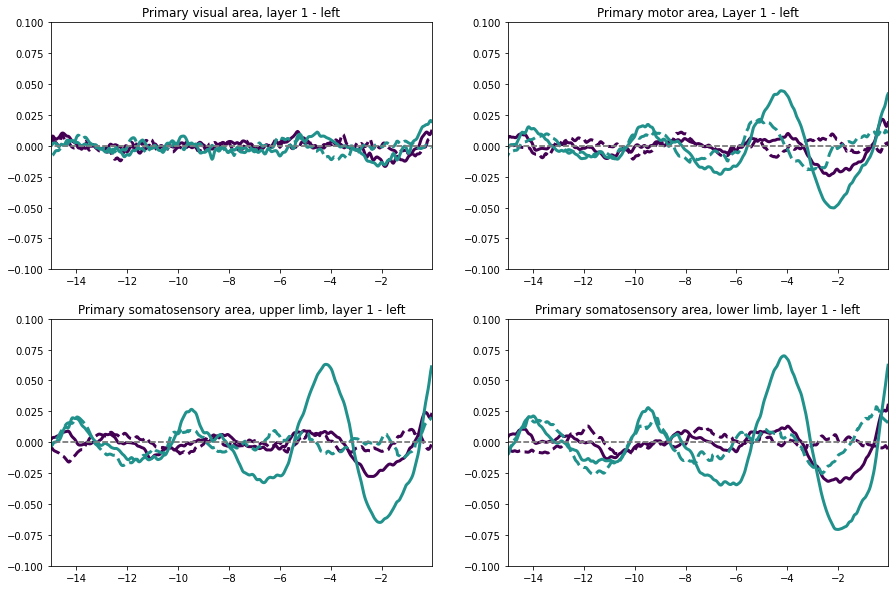

In [3]:
#######################################################
########### LOAD LIMB AREAS AND TIME COURSES ##########
#######################################################

# FIG 6A example of visual vs. limb averages

main_dir = '/media/cat/4TBSSD/yuki/'
animal_id = 'IJ2'
session_ids = ['Feb1_', 'Mar2_','Mar31_','Apr4_']
session_ids = ['Feb3_','Mar2_'] #,'Apr4_']

colors = plt.cm.viridis(np.linspace(0,1,3))
#colors=['black','blue','red','magenta']
# 
plt.figure(figsize=(15,10))
area_ids = [13, 8, 12, 11]
linewidth = 3
plot_roi_averages(main_dir,
                     animal_id,
                     session_ids,
                     colors,
                     area_ids,
                     linewidth)




In [3]:
####################################################################
###### LOAD MEAN AND VARIANCE FOR EACH SESSION ROI ACTIVITY ########
####################################################################
#
animal_id = 'IJ2'
session_name = 'all'
root_dir = '/media/cat/4TBSSD/yuki/'

# 
loca = analysis_fig4.LocaNMFClass(root_dir, animal_id, session_name)

#
loca.get_sessions(session_name)
print ("# of sessions: ", loca.sessions.shape)

all_means = []
n_trials = []
saved_names = []
all_means_random = []
good_sessions = []
all_loca_NMF = []
for session in tqdm(loca.sessions):
    
    # load data
    fname_locaNMF = os.path.join(root_dir, animal_id, 'tif_files',session,
                                 session + '_locanmf.npz')
    atlas, areas, names, locaNMF_temporal, random = load_locaNMF_data(fname_locaNMF)

    # 
    if atlas is not None:
        means, var = variance_locaNMF(locaNMF_temporal)
        n_trials.append(locaNMF_temporal.shape[0])
        all_means.append(means)
        
        means, var = variance_locaNMF(random)
        all_means_random.append(means)
                
        saved_names = names
        good_sessions.append(session)
    
print ("# good sessions: ", len(good_sessions))



  7%|▋         | 3/44 [00:00<00:01, 26.72it/s]

# of sessions:  (44,)
  # trials  (10, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (43, 16, 1801)
  # trials  (47, 16, 1801)


 20%|██        | 9/44 [00:00<00:01, 21.51it/s]

  # trials  (52, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb9_30Hz/IJ2pm_Feb9_30Hz_locanmf.npz
  # trials  (50, 16, 1801)
  # trials  (39, 16, 1801)
  # trials  (26, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb15_30Hz/IJ2pm_Feb15_30Hz_locanmf.npz


 34%|███▍      | 15/44 [00:00<00:01, 25.47it/s]

  # trials  (56, 16, 1801)
  # trials  (12, 16, 1801)
  # trials  (29, 16, 1801)
  # trials  (38, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb23_30Hz/IJ2pm_Feb23_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb24_30Hz/IJ2pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb25_30Hz/IJ2pm_Feb25_30Hz_locanmf.npz


 43%|████▎     | 19/44 [00:00<00:01, 22.42it/s]

  # trials  (64, 16, 1801)
  # trials  (94, 16, 1801)
  # trials  (61, 16, 1801)
  # trials  (106, 16, 1801)
  # trials  (48, 16, 1801)


 57%|█████▋    | 25/44 [00:01<00:01, 18.15it/s]

  # trials  (34, 16, 1801)
  # trials  (21, 16, 1801)
  # trials  (50, 16, 1801)
  # trials  (61, 16, 1801)


 70%|███████   | 31/44 [00:01<00:00, 19.08it/s]

  # trials  (59, 16, 1801)
  # trials  (30, 16, 1801)
  # trials  (28, 16, 1801)
  # trials  (43, 16, 1801)
  # trials  (22, 16, 1801)


 77%|███████▋  | 34/44 [00:01<00:00, 17.89it/s]

  # trials  (44, 16, 1801)
  # trials  (39, 16, 1801)
  # trials  (74, 16, 1801)
  # trials  (33, 16, 1801)


 86%|████████▋ | 38/44 [00:01<00:00, 17.23it/s]

  # trials  (43, 16, 1801)
  # trials  (50, 16, 1801)
  # trials  (64, 16, 1801)
  # trials  (33, 16, 1801)


 95%|█████████▌| 42/44 [00:02<00:00, 15.41it/s]

  # trials  (65, 16, 1801)
  # trials  (82, 16, 1801)
  # trials  (58, 16, 1801)


100%|██████████| 44/44 [00:02<00:00, 18.47it/s]

  # trials  (37, 16, 1801)
  # trials  (60, 16, 1801)
# good sessions:  39


In [12]:
########################################
###### PLOT LONGITUDINAL RESULTS #######
#########################################
# # fig 5F longintudinal power spectra 
# plot_longitudinal_roi_loca(n_trials, saved_names, all_means)   

In [11]:
np.save('/home/cat/all_means_IJ2.npy', all_means)
np.save('/home/cat/all_means_random_IJ2.npy', all_means_random)


['Primary visual area, layer 1 - left'
 'Primary somatosensory area, upper limb, layer 1 - left'
 'Primary motor area, Layer 1 - left'
 'Retrosplenial area, dorsal part, layer 1 - left']
max freq:  0.26666666666666666
max freq:  0.3
max freq:  0.26666666666666666
max freq:  0.26666666666666666


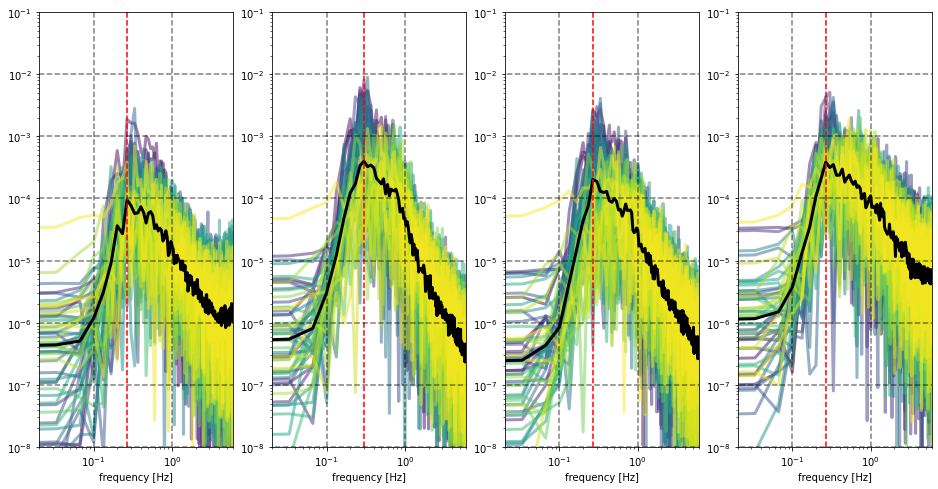

In [5]:
##############################
####### POWER SPECTRUM #######
##############################

# Fig 7b power vs. freq spectra for major regions
colors = []
colors.append(plt.cm.viridis(np.linspace(0,1,len(all_means))))
colors.append(plt.cm.viridis(np.linspace(0,1,len(all_means))))
colors.append(plt.cm.viridis(np.linspace(0,1,len(all_means))))
colors.append(plt.cm.viridis(np.linspace(0,1,len(all_means))))

# 
fs = 30
plotting=True
selected_areas = [11,9,1,15]
print (saved_names[selected_areas])
all_areas = np.arange(all_means[0].shape[0])

#
spectra = plot_spectra_longintudinally(colors,
                                       plotting, 
                                       fs, 
                                       selected_areas, 
                                       all_areas,
                                       all_means,
                                       all_means_random)

#


  4%|▍         | 3/71 [00:00<00:02, 25.75it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb1_30Hz/IA1pm_Feb1_30Hz_locanmf.npz
  # trials  (23, 16, 1801)
  # trials  (58, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb4_30Hz/IA1pm_Feb4_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb5_30Hz/IA1pm_Feb5_30Hz_locanmf.npz
  # trials  (51, 16, 1801)


 17%|█▋        | 12/71 [00:00<00:01, 32.05it/s]

  # trials  (13, 16, 1801)
  # trials  (38, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb12_30Hz/IA1pm_Feb12_30Hz_locanmf.npz
  # trials  (18, 16, 1801)
  # trials  (40, 16, 1801)
  # trials  (36, 16, 1801)
  # trials  (14, 16, 1801)


 23%|██▎       | 16/71 [00:00<00:02, 25.76it/s]

  # trials  (72, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb22_30Hz/IA1pm_Feb22_30Hz_locanmf.npz
  # trials  (76, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb24_30Hz/IA1pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb25_30Hz/IA1pm_Feb25_30Hz_locanmf.npz
  # trials  (11, 16, 1801)
  # trials  (29, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar1_30Hz/IA1pm_Mar1_30Hz_locanmf.npz


 37%|███▋      | 26/71 [00:00<00:01, 34.32it/s]

  # trials  (36, 16, 1801)
  # trials  (24, 16, 1801)
  # trials  (32, 16, 1801)
  # trials  (20, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar8_30Hz/IA1pm_Mar8_30Hz_locanmf.npz
  # trials  (23, 16, 1801)
  # trials  (24, 16, 1801)


 49%|████▉     | 35/71 [00:01<00:01, 34.92it/s]

  # trials  (23, 16, 1801)
  # trials  (44, 16, 1801)
  # trials  (25, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar16_30Hz/IA1pm_Mar16_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (13, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar22_30Hz/IA1pm_Mar22_30Hz_locanmf.npz
  # trials  (12, 16, 1801)


 58%|█████▊    | 41/71 [00:01<00:00, 40.18it/s]

  # trials  (11, 16, 1801)
  # trials  (20, 16, 1801)
  # trials  (13, 16, 1801)
  # trials  (12, 16, 1801)
  # trials  (11, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr4_30Hz/IA1pm_Apr4_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr5_30Hz/IA1pm_Apr5_30Hz_locanmf.npz
  # trials  (17, 16, 1801)
  # trials  (10, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr11_Day3_30Hz/IA1pm_Apr11_Day3_30Hz_locanmf.npz
  # trials  (25, 16, 1801)
  # trials  (20, 16, 1801)


 76%|███████▌  | 54/71 [00:01<00:00, 46.03it/s]

  # trials  (14, 16, 1801)
  # trials  (18, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (39, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr22_Week2_30Hz/IA1pm_Apr22_Week2_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
  # trials  (23, 16, 1801)
  # trials  (17, 16, 1801)


 90%|█████████ | 64/71 [00:01<00:00, 42.30it/s]

  # trials  (13, 16, 1801)
  # trials  (13, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May2_Week4_30Hz/IA1am_May2_Week4_30Hz_locanmf.npz
  # trials  (28, 16, 1801)
  # trials  (11, 16, 1801)
  # trials  (22, 16, 1801)
  # trials  (23, 16, 1801)
  # trials  (22, 16, 1801)


100%|██████████| 71/71 [00:01<00:00, 38.28it/s]


  # trials  (39, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May13_Week5_30Hz/IA1am_May13_Week5_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May16_Week6_30Hz/IA1am_May16_Week6_30Hz_locanmf.npz
  # trials  (29, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (10, 16, 1801)
# good sessions:  53
(53, 4, 451)
0 V1L  y shape:  (53,)
0 corr (0.19437445256470293, 0.16311624941860392)
1 SomFL  y shape:  (53,)
1 corr (0.6079676302981403, 1.3768762096576255e-06)
2 M1L  y shape:  (53,)
2 corr (0.5394733205882425, 3.068433243245289e-05)
3 RDL  y shape:  (53,)
3 corr (0.5118274742448632, 8.95653628143738e-05)


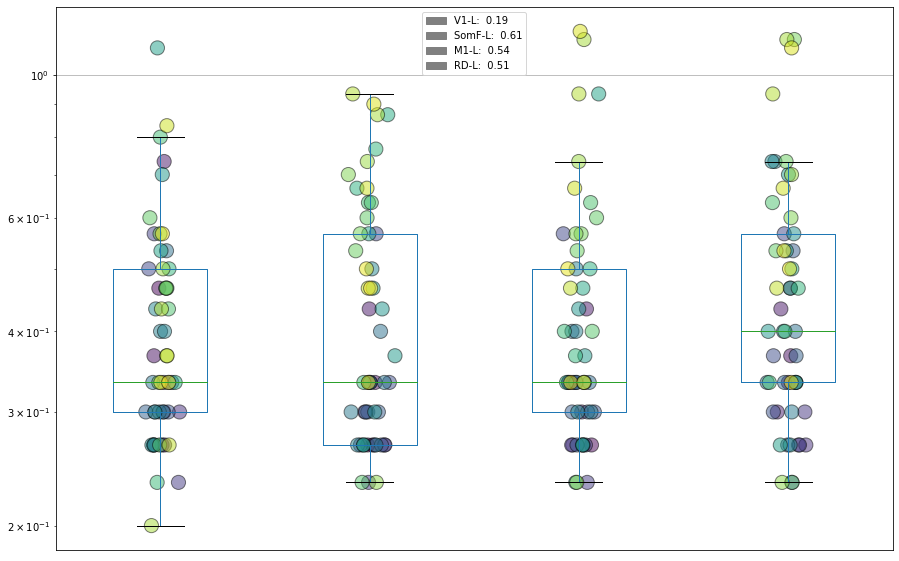

  9%|▉         | 4/44 [00:00<00:01, 25.66it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb1_30Hz/IA2pm_Feb1_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb2_30Hz/IA2pm_Feb2_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
  # trials  (88, 16, 1801)


 20%|██        | 9/44 [00:00<00:00, 35.27it/s]

  # trials  (67, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb9_30Hz/IA2pm_Feb9_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb10_30Hz/IA2pm_Feb10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb11_30Hz/IA2pm_Feb11_30Hz_locanmf.npz
  # trials  (19, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb15_30Hz/IA2pm_Feb15_30Hz_locanmf.npz
  # trials  (48, 16, 1801)
  # trials  (24, 16, 1801)
  # trials  (45, 16, 1801)


 39%|███▊      | 17/44 [00:00<00:00, 30.03it/s]

  # trials  (67, 16, 1801)
  # trials  (42, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb23_30Hz/IA2pm_Feb23_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb24_30Hz/IA2pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb25_30Hz/IA2pm_Feb25_30Hz_locanmf.npz
  # trials  (31, 16, 1801)
  # trials  (59, 16, 1801)


 55%|█████▍    | 24/44 [00:00<00:00, 27.57it/s]

  # trials  (21, 16, 1801)
  # trials  (63, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Mar3_30Hz/IA2pm_Mar3_30Hz_locanmf.npz
  # trials  (32, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2am_Mar7_30Hz/IA2am_Mar7_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
  # trials  (12, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2am_Mar10_30Hz/IA2am_Mar10_30Hz_locanmf.npz


 66%|██████▌   | 29/44 [00:00<00:00, 30.55it/s]

  # trials  (79, 16, 1801)
  # trials  (87, 16, 1801)
  # trials  (63, 16, 1801)


 75%|███████▌  | 33/44 [00:01<00:00, 19.21it/s]

  # trials  (98, 16, 1801)
  # trials  (82, 16, 1801)
  # trials  (61, 16, 1801)


 89%|████████▊ | 39/44 [00:01<00:00, 19.71it/s]

  # trials  (49, 16, 1801)
  # trials  (67, 16, 1801)
  # trials  (45, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Mar29_30Hz/IA2pm_Mar29_30Hz_locanmf.npz
  # trials  (35, 16, 1801)


 95%|█████████▌| 42/44 [00:01<00:00, 17.61it/s]

  # trials  (62, 16, 1801)
  # trials  (85, 16, 1801)
  # trials  (28, 16, 1801)
  # trials  (22, 16, 1801)


100%|██████████| 44/44 [00:01<00:00, 22.15it/s]


  # trials  (62, 16, 1801)
# good sessions:  31
(31, 4, 451)
0 V1L  y shape:  (31,)
0 corr (-0.2981575004119056, 0.10328140051384245)
1 SomFL  y shape:  (31,)
1 corr (-0.5561719296807195, 0.0011588332313313778)
2 M1L  y shape:  (31,)
2 corr (-0.6879678949224832, 1.8951364177999577e-05)
3 RDL  y shape:  (31,)
3 corr (-0.5340621645746129, 0.0019713759242949856)


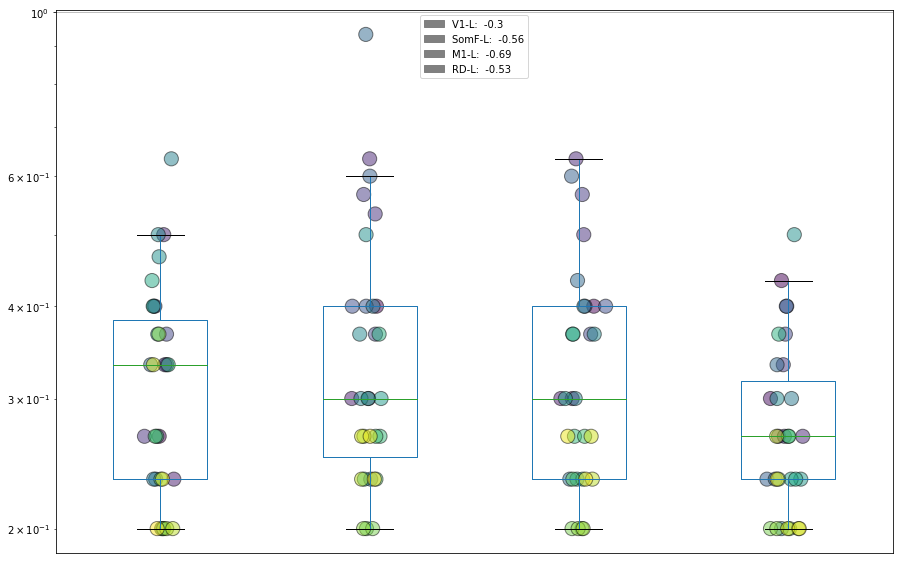

  5%|▍         | 2/44 [00:00<00:02, 17.58it/s]

  # trials  (28, 16, 1801)
  # trials  (65, 16, 1801)
  # trials  (91, 16, 1801)


 18%|█▊        | 8/44 [00:00<00:01, 19.71it/s]

  # trials  (53, 16, 1801)
  # trials  (11, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb10_30Hz/IA3pm_Feb10_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
  # trials  (82, 16, 1801)


 25%|██▌       | 11/44 [00:00<00:01, 17.72it/s]

  # trials  (48, 16, 1801)
  # trials  (66, 16, 1801)
  # trials  (49, 16, 1801)
  # trials  (38, 16, 1801)


 43%|████▎     | 19/44 [00:00<00:01, 24.14it/s]

  # trials  (30, 16, 1801)
  # trials  (24, 16, 1801)
  # trials  (11, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb24_30Hz/IA3pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb25_30Hz/IA3pm_Feb25_30Hz_locanmf.npz
  # trials  (65, 16, 1801)
  # trials  (46, 16, 1801)


 50%|█████     | 22/44 [00:01<00:00, 23.40it/s]

  # trials  (23, 16, 1801)
  # trials  (33, 16, 1801)
  # trials  (51, 16, 1801)
  # trials  (38, 16, 1801)
  # trials  (34, 16, 1801)


 64%|██████▎   | 28/44 [00:01<00:00, 20.96it/s]

  # trials  (40, 16, 1801)
  # trials  (65, 16, 1801)
  # trials  (55, 16, 1801)
  # trials  (22, 16, 1801)


 70%|███████   | 31/44 [00:01<00:00, 19.58it/s]

  # trials  (34, 16, 1801)
  # trials  (47, 16, 1801)
  # trials  (56, 16, 1801)


 75%|███████▌  | 33/44 [00:01<00:00, 15.73it/s]

  # trials  (80, 16, 1801)
  # trials  (106, 16, 1801)


 80%|███████▉  | 35/44 [00:01<00:00, 13.19it/s]

  # trials  (99, 16, 1801)
  # trials  (108, 16, 1801)


 84%|████████▍ | 37/44 [00:02<00:00, 11.31it/s]

  # trials  (130, 16, 1801)
  # trials  (88, 16, 1801)
  # trials  (48, 16, 1801)


 93%|█████████▎| 41/44 [00:02<00:00, 11.91it/s]

  # trials  (95, 16, 1801)
  # trials  (75, 16, 1801)
  # trials  (63, 16, 1801)


 98%|█████████▊| 43/44 [00:02<00:00, 11.14it/s]

  # trials  (117, 16, 1801)
  # trials  (67, 16, 1801)
  # trials  (104, 16, 1801)


100%|██████████| 44/44 [00:02<00:00, 15.35it/s]


# good sessions:  41
(41, 4, 451)
0 V1L  y shape:  (41,)
0 corr (-0.21576947997994214, 0.17545107856797146)
1 SomFL  y shape:  (41,)
1 corr (-0.18245778154863068, 0.2535430168875494)
2 M1L  y shape:  (41,)
2 corr (-0.16862557229687303, 0.29192432847158684)
3 RDL  y shape:  (41,)
3 corr (-0.09937351108289118, 0.5364723617416676)


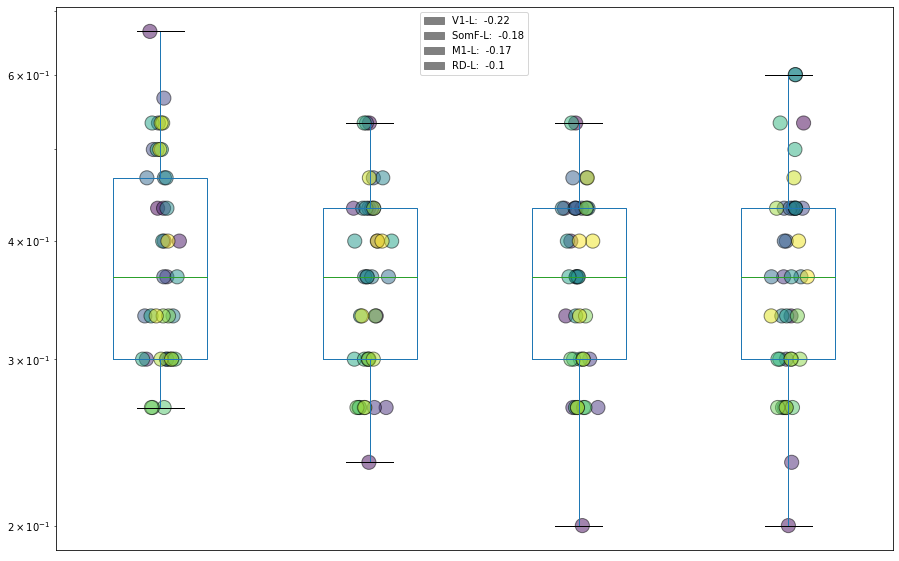

  7%|▋         | 3/44 [00:00<00:01, 23.28it/s]

  # trials  (29, 16, 1801)
  # trials  (31, 16, 1801)
  # trials  (43, 16, 1801)
  # trials  (38, 16, 1801)
  # trials  (44, 16, 1801)


 20%|██        | 9/44 [00:00<00:01, 18.46it/s]

  # trials  (43, 16, 1801)
  # trials  (54, 16, 1801)
  # trials  (49, 16, 1801)
  # trials  (56, 16, 1801)


 32%|███▏      | 14/44 [00:00<00:01, 20.53it/s]

  # trials  (31, 16, 1801)
  # trials  (56, 16, 1801)
  # trials  (27, 16, 1801)
  # trials  (44, 16, 1801)
  # trials  (26, 16, 1801)


 41%|████      | 18/44 [00:00<00:01, 22.30it/s]

  # trials  (82, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Feb24_30Hz/IJ1pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Feb25_30Hz/IJ1pm_Feb25_30Hz_locanmf.npz
  # trials  (46, 16, 1801)
  # trials  (73, 16, 1801)
  # trials  (16, 16, 1801)


 48%|████▊     | 21/44 [00:01<00:01, 19.88it/s]

  # trials  (61, 16, 1801)
  # trials  (132, 16, 1801)


 55%|█████▍    | 24/44 [00:01<00:01, 14.48it/s]

  # trials  (114, 16, 1801)
  # trials  (42, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1am_Mar9_30Hz/IJ1am_Mar9_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
  # trials  (18, 16, 1801)
  # trials  (10, 16, 1801)


 73%|███████▎  | 32/44 [00:01<00:00, 20.61it/s]

  # trials  (44, 16, 1801)
  # trials  (32, 16, 1801)
  # trials  (21, 16, 1801)
  # trials  (42, 16, 1801)
  # trials  (12, 16, 1801)
  # trials  (19, 16, 1801)
  # trials  (20, 16, 1801)


 89%|████████▊ | 39/44 [00:01<00:00, 23.72it/s]

  # trials  (21, 16, 1801)
  # trials  (19, 16, 1801)
  # trials  (41, 16, 1801)
  # trials  (47, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (27, 16, 1801)


100%|██████████| 44/44 [00:02<00:00, 21.79it/s]


  # trials  (37, 16, 1801)
  # trials  (26, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Apr7_30Hz/IJ1pm_Apr7_30Hz_locanmf.npz
# good sessions:  40
(40, 4, 451)
0 V1L  y shape:  (40,)
0 corr (0.31869689220644126, 0.0450375711188844)
1 SomFL  y shape:  (40,)
1 corr (0.187851779324123, 0.2457336372579979)
2 M1L  y shape:  (40,)
2 corr (0.26954232900695135, 0.09257479788117409)
3 RDL  y shape:  (40,)
3 corr (0.10265599662043433, 0.5284757929772151)


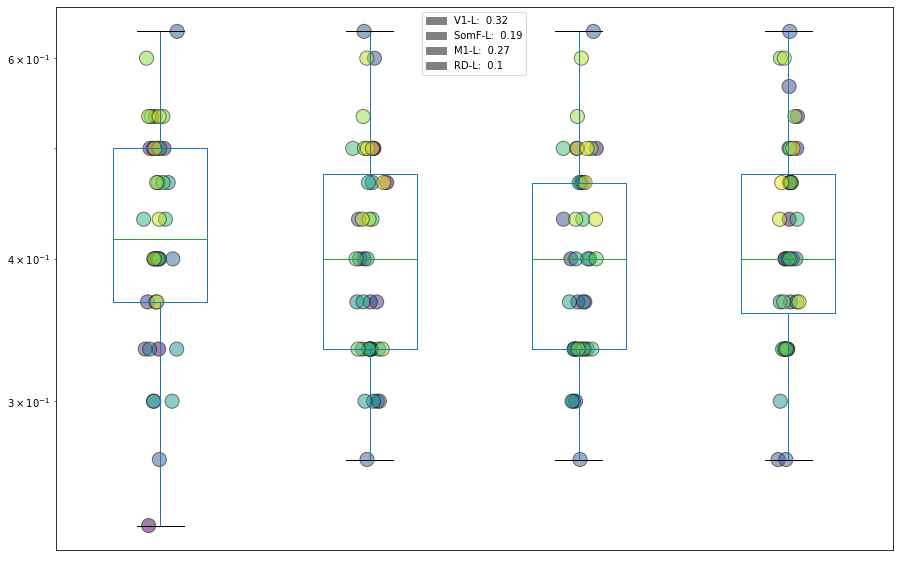

  7%|▋         | 3/44 [00:00<00:01, 27.06it/s]

  # trials  (10, 16, 1801)
  # trials  (16, 16, 1801)
  # trials  (43, 16, 1801)
  # trials  (47, 16, 1801)


 20%|██        | 9/44 [00:00<00:01, 22.34it/s]

  # trials  (52, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb9_30Hz/IJ2pm_Feb9_30Hz_locanmf.npz
  # trials  (50, 16, 1801)
  # trials  (39, 16, 1801)
  # trials  (26, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb15_30Hz/IJ2pm_Feb15_30Hz_locanmf.npz


 41%|████      | 18/44 [00:00<00:00, 31.48it/s]

  # trials  (56, 16, 1801)
  # trials  (12, 16, 1801)
  # trials  (29, 16, 1801)
  # trials  (38, 16, 1801)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb23_30Hz/IJ2pm_Feb23_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb24_30Hz/IJ2pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb25_30Hz/IJ2pm_Feb25_30Hz_locanmf.npz
  # trials  (64, 16, 1801)
  # trials  (94, 16, 1801)
  # trials  (61, 16, 1801)
  # trials  (106, 16, 1801)


 57%|█████▋    | 25/44 [00:01<00:00, 19.80it/s]

  # trials  (48, 16, 1801)
  # trials  (34, 16, 1801)
  # trials  (21, 16, 1801)
  # trials  (50, 16, 1801)


 64%|██████▎   | 28/44 [00:01<00:00, 18.81it/s]

  # trials  (61, 16, 1801)
  # trials  (59, 16, 1801)
  # trials  (30, 16, 1801)
  # trials  (28, 16, 1801)
  # trials  (43, 16, 1801)


 77%|███████▋  | 34/44 [00:01<00:00, 19.03it/s]

  # trials  (22, 16, 1801)
  # trials  (44, 16, 1801)
  # trials  (39, 16, 1801)
  # trials  (74, 16, 1801)


 84%|████████▍ | 37/44 [00:01<00:00, 18.74it/s]

  # trials  (33, 16, 1801)
  # trials  (43, 16, 1801)
  # trials  (50, 16, 1801)
  # trials  (64, 16, 1801)


 93%|█████████▎| 41/44 [00:02<00:00, 16.22it/s]

  # trials  (33, 16, 1801)
  # trials  (65, 16, 1801)
  # trials  (82, 16, 1801)


100%|██████████| 44/44 [00:02<00:00, 19.47it/s]


  # trials  (58, 16, 1801)
  # trials  (37, 16, 1801)
  # trials  (60, 16, 1801)
# good sessions:  39
(39, 4, 451)
0 V1L  y shape:  (39,)
0 corr (0.3550264067412439, 0.026567838607618854)
1 SomFL  y shape:  (39,)
1 corr (0.2983009596479717, 0.06510676129250421)
2 M1L  y shape:  (39,)
2 corr (0.31209753599995055, 0.05308149187599243)
3 RDL  y shape:  (39,)
3 corr (0.11267772629395281, 0.4946335122631921)


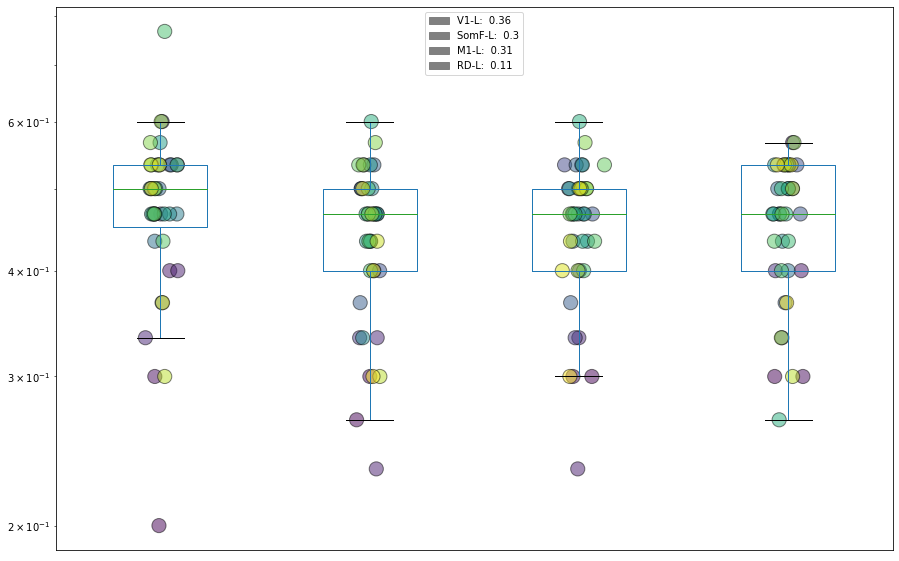

 14%|█▎        | 15/110 [00:00<00:00, 116.44it/s]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec9_30Hz/AQ2am_Dec9_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec10_30Hz/AQ2am_Dec10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec10_30Hz/AQ2pm_Dec10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec11_30Hz/AQ2am_Dec11_30Hz_locanmf.npz
  # trials  (9, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec14_30Hz/AQ2am_Dec14_30Hz_locanmf.npz
  # trials  (26, 16, 1801)
  # trials  (21, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec17_30Hz/AQ2pm_Dec17_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec18_30Hz/AQ2am_Dec18_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec18_30Hz/AQ2pm_Dec18_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec21_30Hz/AQ2am_Dec21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_De

 25%|██▍       | 27/110 [00:00<00:01, 47.09it/s] 

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan7_30Hz/AQ2am_Jan7_30Hz_locanmf.npz
  # trials  (27, 16, 1801)
  # trials  (17, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan11_30Hz/AQ2am_Jan11_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan12_30Hz/AQ2pm_Jan12_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan12_30Hz/AQ2am_Jan12_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
  # trials  (54, 16, 1801)


 31%|███       | 34/110 [00:00<00:02, 34.30it/s]

  # trials  (37, 16, 1801)
  # trials  (42, 16, 1801)
  # trials  (26, 16, 1801)
  # trials  (70, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan18_30Hz/AQ2pm_Jan18_30Hz_locanmf.npz
  # trials  (12, 16, 1801)


 45%|████▍     | 49/110 [00:00<00:01, 54.28it/s]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan19_30Hz/AQ2am_Jan19_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan19_30Hz/AQ2pm_Jan19_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan20_30Hz/AQ2pm_Jan20_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan20_30Hz/AQ2am_Jan20_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan21_30Hz/AQ2pm_Jan21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan21_30Hz/AQ2am_Jan21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan22_30Hz/AQ2pm_Jan22_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan22_30Hz/AQ2am_Jan22_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan25_30Hz/AQ2am_Jan25_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan25_30Hz/AQ2pm_Jan25_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/

 53%|█████▎    | 58/110 [00:01<00:01, 30.32it/s]

  # trials  (91, 16, 1801)
  # trials  (93, 16, 1801)
  # trials  (131, 16, 1801)
  # trials  (184, 16, 1801)
  # trials  (157, 16, 1801)
  # trials  (145, 16, 1801)


 58%|█████▊    | 64/110 [00:02<00:02, 16.61it/s]

  # trials  (104, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Feb18_30Hz/AQ2am_Feb18_30Hz_locanmf.npz
  # trials  (96, 16, 1801)


 63%|██████▎   | 69/110 [00:02<00:02, 15.41it/s]

  # trials  (144, 16, 1801)
  # trials  (120, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Feb25_30Hz/AQ2am_Feb25_30Hz_locanmf.npz
  # trials  (92, 16, 1801)
  # trials  (90, 16, 1801)


 66%|██████▋   | 73/110 [00:03<00:02, 13.67it/s]

  # trials  (125, 16, 1801)
  # trials  (58, 16, 1801)
  # trials  (129, 16, 1801)
  # trials  (109, 16, 1801)


 69%|██████▉   | 76/110 [00:03<00:02, 12.43it/s]

  # trials  (70, 16, 1801)
  # trials  (99, 16, 1801)


 71%|███████   | 78/110 [00:03<00:02, 11.86it/s]

  # trials  (103, 16, 1801)
  # trials  (143, 16, 1801)


 73%|███████▎  | 80/110 [00:04<00:02, 10.51it/s]

  # trials  (122, 16, 1801)
  # trials  (104, 16, 1801)


 76%|███████▋  | 84/110 [00:04<00:02, 10.57it/s]

  # trials  (139, 16, 1801)
  # trials  (47, 16, 1801)
  # trials  (64, 16, 1801)


 78%|███████▊  | 86/110 [00:04<00:02,  9.91it/s]

  # trials  (84, 16, 1801)
  # trials  (124, 16, 1801)


 80%|████████  | 88/110 [00:05<00:02,  9.17it/s]

  # trials  (91, 16, 1801)
  # trials  (147, 16, 1801)


 82%|████████▏ | 90/110 [00:05<00:02,  8.39it/s]

  # trials  (114, 16, 1801)
  # trials  (137, 16, 1801)


 84%|████████▎ | 92/110 [00:05<00:02,  8.39it/s]

  # trials  (127, 16, 1801)
  # trials  (100, 16, 1801)


 85%|████████▌ | 94/110 [00:05<00:01,  8.44it/s]

  # trials  (117, 16, 1801)
  # trials  (93, 16, 1801)


 87%|████████▋ | 96/110 [00:06<00:01,  7.86it/s]

  # trials  (104, 16, 1801)
  # trials  (142, 16, 1801)


 90%|█████████ | 99/110 [00:06<00:01, 10.83it/s]

  # trials  (94, 16, 1801)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Apr13_Week6_30Hz/AQ2am_Apr13_Week6_30Hz_locanmf.npz
  # trials  (98, 16, 1801)


 92%|█████████▏| 101/110 [00:06<00:00, 10.87it/s]

  # trials  (83, 16, 1801)
  # trials  (77, 16, 1801)
  # trials  (70, 16, 1801)


 93%|█████████▎| 102/110 [00:06<00:00, 15.17it/s]


  # trials  (69, 16, 1801)



KeyboardInterrupt



In [6]:
##################################################
###### PEAK POWER AND PEAK FREQUENCY PLOTS #######
##################################################

session_name = 'all'
root_dir = '/media/cat/4TBSSD/yuki/'

plot_peak_frequency = True
plot_peak_power = False
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']#,'IA2','IA3','IJ1','IJ2','AQ2']


all_peaks = []
all_power = []
for animal_id in animal_ids:

    ##############################################
    ########### GET LOCA COMPONENTS ##############
    ##############################################
    loca = analysis_fig4.LocaNMFClass(root_dir, animal_id, session_name)

    #
    loca.get_sessions(session_name)
    #print ("# of sessions: ", loca.sessions.shape)

    all_means = []
    n_trials = []
    saved_names = []
    all_means_random = []
    good_sessions = []
    for session in tqdm(loca.sessions):

        # load data
        fname_locaNMF = os.path.join(root_dir, animal_id, 'tif_files',session,
                                     session + '_locanmf.npz')
        atlas, areas, names, locaNMF_temporal, random = load_locaNMF_data(fname_locaNMF)

        # 
        if atlas is not None:
            means, var = variance_locaNMF(locaNMF_temporal)
            n_trials.append(locaNMF_temporal.shape[0])
            all_means.append(means)

            means, var = variance_locaNMF(random)
            all_means_random.append(means)

            saved_names = names
            good_sessions.append(session)
    
    print ("# good sessions: ", len(good_sessions))
        
    ##############################################
    ########### GET SPECTRA ######################
    ##############################################
    fs = 30
    plotting=False
    selected_areas = [11,9,1,15]
    #print (saved_names[selected_areas])
    all_areas = np.arange(all_means[0].shape[0])

    #
    spectra = plot_spectra_longintudinally(colors, plotting, fs, selected_areas, 
                                all_areas,
                                all_means,
                                all_means_random)

    #####################################
    ########### PLOT POWER ##############
    #####################################
    print (spectra.shape)
    x = np.arange(0,451,1)/30.

    peaks = []
    for a in range(spectra.shape[1]):
        peaks.append([])
        for s in range(spectra.shape[0]):
            temp = spectra[s,a]
            argmax = np.argmax(temp)

            # plot peak frequency
            if plot_peak_frequency:
                peaks[a].append(x[argmax])
            # plot frequency power
            elif plot_peak_power:
                peaks[a].append(temp[argmax])

    ############
    fig = plt.figure(figsize=(15,10))
    plot_box_plots(peaks)
    all_peaks.append(peaks)
    all_power.append(peaks)

    if False:
        plt.savefig('/home/cat/'+animal_id+'_peakpower.svg')
        plt.close()
    else:
        plt.show()

In [18]:
np.save('/home/cat/all_power.npy',all_power)
np.save('/home/cat/all_peaks.npy',all_peaks)


In [22]:
from sklearn.linear_model import LinearRegression
from scipy import stats

#########################################
ids = [0,2,3]
#feats = ['motor','visual','Retro','limb','barrel']
clrs_local = ['magenta','brown','pink','lightblue','darkblue']

feats_ = ['visual','limb','motor','Retro']
clrs_local_ = ['brown','lightblue','magenta','pink']

ids_ = np.array([1,2,3])
# 
animal_id = 0
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
#animal_ids = ['IA1']#,'IA2','IA3','IJ1','IJ2','AQ2']

# 
fig=plt.figure(figsize=(10,10))
for ctr_animal, animal_id in enumerate(animal_ids):
    #maxes = all_peaks[ctr_animal]
    maxes = all_power[ctr_animal]
    #print ("maxes: ", maxes)
    
    ax=plt.subplot(3,2,ctr_animal+1)

    ctr=0
    for id_ in ids:
        m = np.array(maxes[id_])

        ##################################
        ##################################
        ##################################
        corr = stats.pearsonr(np.arange(m.shape[0]), m)
        print (animal_id, id_, "corr: ", corr)


        model = LinearRegression()
        y=np.array(m).reshape(-1, 1)
        x = np.arange(y.shape[0]).reshape(-1, 1)
        model.fit(x, y)

        x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
        y_pred = model.intercept_ + model.coef_ * x2


        # compute correlation between time and location

        # compute correlation between time and location
        if corr[1]>0.05:
            plt.plot(x2, y_pred,
                 #label= str(np.round(corr,2)),
                  c=clrs_local[id_],
                  #label=feat_names[id_],
                 linewidth=6)
        else:
            plt.plot(x2, y_pred,
                 #label= str(np.round(corr,2)),
                  c=clrs_local[id_],
                  #label=feat_names[id_]+"pcor: "+str(round(corr[0],5))+
                  label="pcor: "+str(round(corr[0],2))+
                 "\npval: "+str(round(corr[1],5)),
                 linewidth=6)

                      # 
        #patch = mpatches.Patch(color='grey', label=feats[id_]+ ":  "+str(round(corr[0],2)))

        # handles is a list, so append manual patch
        #labels.append(patch) 

        ##################################
        ##################################
        ##################################
        # 
        plt.scatter(np.arange(m.shape[0]), m,
                   c=clrs_local[id_],
                    edgecolor='black',
                    s=100,
                   alpha=.3)

        #
        #plt.title(feats[id_])
        #ax.set_ylim(0, 1)
        #ax.set_ylim(0, 0.005)
        #ax.set_xlim(0,x[-1])
        ctr+=1
        plt.legend(fontsize=10)
    print ('')
if True:
    #plt.savefig('/home/cat/fit_trends_psd_averages_frequency.svg')
    plt.savefig('/home/cat/fit_trends_psd_averages_power.svg')
    plt.close()
else:
    plt.show()



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


IA1 0 corr:  (-0.40534632937711707, 0.002603848892550626)
IA1 2 corr:  (-0.5874394119985614, 3.7616639962989067e-06)
IA1 3 corr:  (-0.38042484439657004, 0.004954238982763876)

IA2 0 corr:  (0.14900085037742306, 0.42371637425178843)
IA2 2 corr:  (0.3872448722777934, 0.031377087928112134)
IA2 3 corr:  (0.047145435381875586, 0.8011589030163315)

IA3 0 corr:  (-0.19101239595049782, 0.2315775603196188)
IA3 2 corr:  (0.29985704639392124, 0.05681475194112965)
IA3 3 corr:  (0.2635073697352977, 0.09598107269510982)

IJ1 0 corr:  (0.20099847365942333, 0.21362676663062438)
IJ1 2 corr:  (0.24145761817045583, 0.13335641268762216)
IJ1 3 corr:  (0.5788877637648339, 9.107036164115807e-05)

IJ2 0 corr:  (-0.21536025310058876, 0.18794627821320992)
IJ2 2 corr:  (-0.11392496941430799, 0.48983771173716756)
IJ2 3 corr:  (0.10481198634522296, 0.5254236496869793)



No handles with labels found to put in legend.


AQ2 0 corr:  (-0.20692285361910623, 0.07097487029005053)
AQ2 2 corr:  (0.25421766452532457, 0.02567750254128938)
AQ2 3 corr:  (-0.1033110477260646, 0.3712584631866783)



In [24]:
np.save('/home/cat/saved_names.npy',saved_names)

### HERE we repeat above functions but for individaul sessions


In [8]:
####################################################################
###### LOAD MEAN AND VARIANCE FOR EACH SESSION ROI ACTIVITY ########
####################################################################
#
from scipy import signal
def compute_psd(data):
    print (data.shape)
    
    fs = 30
    rois = []
    for roi in range(data.shape[1]):
        
        psd = []
        for t in range(data.shape[0]):
            x=data[t,roi]
            f, Pxx_den = signal.periodogram(x, fs)
            psd.append(Pxx_den)
            
        psd=np.vstack(psd)
        psd = np.median(psd,axis=0)
        rois.append(psd)
        
    return rois, f

def compute_psd_whole_stack(data):
    print (data.shape)
    
    fs = 30
    rois = []
    for roi in range(data.shape[0]):
        x = data[roi]
        f, Pxx_den = signal.periodogram(x, fs)
        rois.append(Pxx_den)
                  
    return rois, f

def load_locaNMF_wholestack(root_dir,
                           animal_id,
                           session):
    fname = os.path.join(root_dir,
                                   animal_id,
                         'tif_files',
                                    session,
                                    session+'_locanmf_wholestack.npz')
    print (fname)
    try:
        data = np.load(fname, 
                       allow_pickle=True)

        trials = data['whole_stack']
        print (trials.shape)

        return trials
    except:
        return None

###########################################



session_name = 'all'
root_dir = '/media/cat/4TBSSD/yuki/'

#animal_id = 'AQ2'
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
ctr=0
for animal_id in animal_ids:
    # 
    loca = analysis_fig4.LocaNMFClass(root_dir, animal_id, session_name)

    #
    loca.get_sessions(session_name)
    print ("# of sessions: ", loca.sessions.shape)

    all_means = []
    n_trials = []
    saved_names = []
    all_means_random = []
    good_sessions = []
    all_loca_NMF = []
    psds = []

    # 
    psds_random = []

    t1 = 0
    t2 = 1800
                     #/home/cat/psds_AQ2.npy
    fname_out = '/home/cat/psds_'+animal_id+'_single_sessions.npy'
    
    if os.path.exists(fname_out)==True:

        for session in tqdm(loca.sessions):

            # load data
            if True:
                fname_locaNMF = os.path.join(root_dir, animal_id, 'tif_files',session,
                                             session + '_locanmf.npz')
                atlas, areas, names, locaNMF_temporal, random = load_locaNMF_data(fname_locaNMF)

                #  
                if atlas is not None:

                    psd, f = compute_psd(locaNMF_temporal[:,:,t1:t2])
                    psds.append(psd)
                    psd, f = compute_psd(random[:,:,t1:t2])
                    psds_random.append(psd)

                    #
                    n_trials.append(locaNMF_temporal.shape[0])
                    saved_names = names
                    good_sessions.append(session)
                    #break

            else:
                trials = load_locaNMF_wholestack(root_dir,
                                               animal_id,
                                               session)

                if trials is not None:
                    psd, f = compute_psd_whole_stack(trials)
                    psds.append(psd)



            ctr+=1


        print ("# good sessions: ", len(good_sessions))
        #break
        
        
        np.save(fname_out, psds)
    else:
        print ("file already processed......")
        
print ("... DONE ...")

  0%|          | 0/71 [00:00<?, ?it/s]

# of sessions:  (71,)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb1_30Hz/IA1pm_Feb1_30Hz_locanmf.npz
  # trials  (23, 16, 1801)
(23, 16, 1800)
(23, 16, 1800)


  3%|▎         | 2/71 [00:00<00:08,  7.86it/s]

  # trials  (58, 16, 1801)
(58, 16, 1800)
(58, 16, 1800)


  4%|▍         | 3/71 [00:00<00:22,  3.00it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb4_30Hz/IA1pm_Feb4_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb5_30Hz/IA1pm_Feb5_30Hz_locanmf.npz
  # trials  (51, 16, 1801)
(51, 16, 1800)
(51, 16, 1800)


 10%|▉         | 7/71 [00:01<00:13,  4.63it/s]

  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)
  # trials  (38, 16, 1801)
(38, 16, 1800)


 11%|█▏        | 8/71 [00:01<00:16,  3.79it/s]

(38, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb12_30Hz/IA1pm_Feb12_30Hz_locanmf.npz


 14%|█▍        | 10/71 [00:02<00:11,  5.11it/s]

  # trials  (18, 16, 1801)
(18, 16, 1800)
(18, 16, 1800)
  # trials  (40, 16, 1801)
(40, 16, 1800)
(40, 16, 1800)


 15%|█▌        | 11/71 [00:02<00:14,  4.01it/s]

  # trials  (36, 16, 1801)
(36, 16, 1800)
(36, 16, 1800)


 18%|█▊        | 13/71 [00:03<00:14,  3.97it/s]

  # trials  (14, 16, 1801)
(14, 16, 1800)
(14, 16, 1800)
  # trials  (72, 16, 1801)
(72, 16, 1800)
(72, 16, 1800)


 20%|█▉        | 14/71 [00:03<00:22,  2.57it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb22_30Hz/IA1pm_Feb22_30Hz_locanmf.npz
  # trials  (76, 16, 1801)
(76, 16, 1800)
(76, 16, 1800)


 27%|██▋       | 19/71 [00:04<00:11,  4.46it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb24_30Hz/IA1pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb25_30Hz/IA1pm_Feb25_30Hz_locanmf.npz
  # trials  (11, 16, 1801)
(11, 16, 1800)
(11, 16, 1800)
  # trials  (29, 16, 1801)
(29, 16, 1800)


 28%|██▊       | 20/71 [00:05<00:12,  4.15it/s]

(29, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar1_30Hz/IA1pm_Mar1_30Hz_locanmf.npz
  # trials  (36, 16, 1801)
(36, 16, 1800)


 31%|███       | 22/71 [00:05<00:11,  4.44it/s]

(36, 16, 1800)
  # trials  (24, 16, 1801)
(24, 16, 1800)
(24, 16, 1800)


 32%|███▏      | 23/71 [00:05<00:11,  4.30it/s]

  # trials  (32, 16, 1801)
(32, 16, 1800)
(32, 16, 1800)


 35%|███▌      | 25/71 [00:06<00:11,  4.01it/s]

  # trials  (20, 16, 1801)
(20, 16, 1800)
(20, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar8_30Hz/IA1pm_Mar8_30Hz_locanmf.npz
  # trials  (23, 16, 1801)
(23, 16, 1800)
(23, 16, 1800)


 38%|███▊      | 27/71 [00:06<00:08,  5.02it/s]

  # trials  (24, 16, 1801)
(24, 16, 1800)
(24, 16, 1800)


 39%|███▉      | 28/71 [00:06<00:09,  4.68it/s]

  # trials  (23, 16, 1801)
(23, 16, 1800)
(23, 16, 1800)


 41%|████      | 29/71 [00:07<00:09,  4.49it/s]

  # trials  (44, 16, 1801)
(44, 16, 1800)
(44, 16, 1800)


 42%|████▏     | 30/71 [00:07<00:11,  3.49it/s]

  # trials  (25, 16, 1801)
(25, 16, 1800)
(25, 16, 1800)


 46%|████▋     | 33/71 [00:08<00:07,  5.21it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar16_30Hz/IA1pm_Mar16_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)
  # trials  (16, 16, 1801)
(16, 16, 1800)


 48%|████▊     | 34/71 [00:08<00:07,  5.28it/s]

(16, 16, 1800)
  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)


 52%|█████▏    | 37/71 [00:08<00:04,  7.54it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Mar22_30Hz/IA1pm_Mar22_30Hz_locanmf.npz
  # trials  (12, 16, 1801)
(12, 16, 1800)
(12, 16, 1800)
  # trials  (11, 16, 1801)
(11, 16, 1800)


 54%|█████▎    | 38/71 [00:08<00:04,  7.63it/s]

(11, 16, 1800)
  # trials  (20, 16, 1801)
(20, 16, 1800)
(20, 16, 1800)


 56%|█████▋    | 40/71 [00:08<00:04,  6.61it/s]

  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)
  # trials  (12, 16, 1801)
(12, 16, 1800)


 59%|█████▉    | 42/71 [00:09<00:04,  7.08it/s]

(12, 16, 1800)
  # trials  (11, 16, 1801)
(11, 16, 1800)
(11, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr4_30Hz/IA1pm_Apr4_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr5_30Hz/IA1pm_Apr5_30Hz_locanmf.npz


 63%|██████▎   | 45/71 [00:09<00:02, 10.15it/s]

  # trials  (17, 16, 1801)
(17, 16, 1800)
(17, 16, 1800)
  # trials  (10, 16, 1801)
(10, 16, 1800)


 65%|██████▍   | 46/71 [00:09<00:02,  9.77it/s]

(10, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr11_Day3_30Hz/IA1pm_Apr11_Day3_30Hz_locanmf.npz
  # trials  (25, 16, 1801)
(25, 16, 1800)
(25, 16, 1800)


 69%|██████▉   | 49/71 [00:10<00:03,  7.32it/s]

  # trials  (20, 16, 1801)
(20, 16, 1800)
(20, 16, 1800)


 70%|███████   | 50/71 [00:10<00:02,  7.05it/s]

  # trials  (14, 16, 1801)
(14, 16, 1800)
(14, 16, 1800)
  # trials  (18, 16, 1801)
(18, 16, 1800)


 72%|███████▏  | 51/71 [00:10<00:03,  6.35it/s]

(18, 16, 1800)
  # trials  (16, 16, 1801)
(16, 16, 1800)
(16, 16, 1800)


 73%|███████▎  | 52/71 [00:10<00:03,  6.11it/s]

  # trials  (39, 16, 1801)
(39, 16, 1800)
(39, 16, 1800)


 75%|███████▍  | 53/71 [00:11<00:04,  4.31it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Apr22_Week2_30Hz/IA1pm_Apr22_Week2_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
(37, 16, 1800)


 77%|███████▋  | 55/71 [00:11<00:03,  4.61it/s]

(37, 16, 1800)
  # trials  (23, 16, 1801)
(23, 16, 1800)
(23, 16, 1800)


 80%|████████  | 57/71 [00:11<00:03,  4.64it/s]

  # trials  (17, 16, 1801)
(17, 16, 1800)
(17, 16, 1800)
  # trials  (13, 16, 1801)
(13, 16, 1800)


 82%|████████▏ | 58/71 [00:11<00:02,  5.07it/s]

(13, 16, 1800)
  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)


 83%|████████▎ | 59/71 [00:12<00:02,  5.44it/s]

file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May2_Week4_30Hz/IA1am_May2_Week4_30Hz_locanmf.npz
  # trials  (28, 16, 1801)
(28, 16, 1800)
(28, 16, 1800)


 87%|████████▋ | 62/71 [00:12<00:01,  6.30it/s]

  # trials  (11, 16, 1801)
(11, 16, 1800)
(11, 16, 1800)
  # trials  (22, 16, 1801)
(22, 16, 1800)


 89%|████████▊ | 63/71 [00:12<00:01,  5.57it/s]

(22, 16, 1800)
  # trials  (23, 16, 1801)
(23, 16, 1800)


 90%|█████████ | 64/71 [00:13<00:01,  5.05it/s]

(23, 16, 1800)
  # trials  (22, 16, 1801)
(22, 16, 1800)


 92%|█████████▏| 65/71 [00:13<00:01,  4.76it/s]

(22, 16, 1800)
  # trials  (39, 16, 1801)
(39, 16, 1800)


 93%|█████████▎| 66/71 [00:13<00:01,  3.73it/s]

(39, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May13_Week5_30Hz/IA1am_May13_Week5_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_May16_Week6_30Hz/IA1am_May16_Week6_30Hz_locanmf.npz
  # trials  (29, 16, 1801)
(29, 16, 1800)
(29, 16, 1800)


 99%|█████████▊| 70/71 [00:14<00:00,  5.61it/s]

  # trials  (16, 16, 1801)
(16, 16, 1800)
(16, 16, 1800)
  # trials  (10, 16, 1801)
(10, 16, 1800)


  0%|          | 0/44 [00:00<?, ?it/s]

(10, 16, 1800)
# good sessions:  53
# of sessions:  (44,)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb1_30Hz/IA2pm_Feb1_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb2_30Hz/IA2pm_Feb2_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
(37, 16, 1800)


  7%|▋         | 3/44 [00:00<00:05,  7.46it/s]

(37, 16, 1800)
  # trials  (88, 16, 1801)
(88, 16, 1800)
(88, 16, 1800)


  9%|▉         | 4/44 [00:01<00:15,  2.57it/s]

  # trials  (67, 16, 1801)
(67, 16, 1800)
(67, 16, 1800)


 11%|█▏        | 5/44 [00:02<00:19,  2.03it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb9_30Hz/IA2pm_Feb9_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb10_30Hz/IA2pm_Feb10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb11_30Hz/IA2pm_Feb11_30Hz_locanmf.npz
  # trials  (19, 16, 1801)
(19, 16, 1800)
(19, 16, 1800)


 20%|██        | 9/44 [00:02<00:07,  4.75it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb15_30Hz/IA2pm_Feb15_30Hz_locanmf.npz
  # trials  (48, 16, 1801)
(48, 16, 1800)
(48, 16, 1800)


 25%|██▌       | 11/44 [00:02<00:07,  4.44it/s]

  # trials  (24, 16, 1801)
(24, 16, 1800)
(24, 16, 1800)


 27%|██▋       | 12/44 [00:03<00:07,  4.30it/s]

  # trials  (45, 16, 1801)
(45, 16, 1800)
(45, 16, 1800)


 30%|██▉       | 13/44 [00:03<00:08,  3.52it/s]

  # trials  (67, 16, 1801)
(67, 16, 1800)
(67, 16, 1800)


 32%|███▏      | 14/44 [00:04<00:11,  2.62it/s]

  # trials  (42, 16, 1801)
(42, 16, 1800)
(42, 16, 1800)


 34%|███▍      | 15/44 [00:04<00:11,  2.51it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb23_30Hz/IA2pm_Feb23_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb24_30Hz/IA2pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Feb25_30Hz/IA2pm_Feb25_30Hz_locanmf.npz
  # trials  (31, 16, 1801)
(31, 16, 1800)
(31, 16, 1800)


 43%|████▎     | 19/44 [00:05<00:05,  4.65it/s]

  # trials  (59, 16, 1801)
(59, 16, 1800)
(59, 16, 1800)


 45%|████▌     | 20/44 [00:05<00:06,  3.50it/s]

  # trials  (21, 16, 1801)
(21, 16, 1800)
(21, 16, 1800)


 48%|████▊     | 21/44 [00:05<00:06,  3.64it/s]

  # trials  (63, 16, 1801)
(63, 16, 1800)
(63, 16, 1800)


 50%|█████     | 22/44 [00:06<00:07,  2.77it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Mar3_30Hz/IA2pm_Mar3_30Hz_locanmf.npz
  # trials  (32, 16, 1801)
(32, 16, 1800)
(32, 16, 1800)


 59%|█████▉    | 26/44 [00:07<00:03,  4.72it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2am_Mar7_30Hz/IA2am_Mar7_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)
  # trials  (12, 16, 1801)
(12, 16, 1800)


 61%|██████▏   | 27/44 [00:07<00:03,  5.07it/s]

(12, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2am_Mar10_30Hz/IA2am_Mar10_30Hz_locanmf.npz
  # trials  (79, 16, 1801)
(79, 16, 1800)
(79, 16, 1800)


 66%|██████▌   | 29/44 [00:08<00:04,  3.60it/s]

  # trials  (87, 16, 1801)
(87, 16, 1800)
(87, 16, 1800)


 68%|██████▊   | 30/44 [00:08<00:05,  2.45it/s]

  # trials  (63, 16, 1801)
(63, 16, 1800)
(63, 16, 1800)


 70%|███████   | 31/44 [00:09<00:06,  2.14it/s]

  # trials  (98, 16, 1801)
(98, 16, 1800)
(98, 16, 1800)


 73%|███████▎  | 32/44 [00:10<00:07,  1.66it/s]

  # trials  (82, 16, 1801)
(82, 16, 1800)
(82, 16, 1800)


 75%|███████▌  | 33/44 [00:11<00:07,  1.50it/s]

  # trials  (61, 16, 1801)
(61, 16, 1800)
(61, 16, 1800)


 77%|███████▋  | 34/44 [00:12<00:06,  1.51it/s]

  # trials  (49, 16, 1801)
(49, 16, 1800)
(49, 16, 1800)


 80%|███████▉  | 35/44 [00:12<00:05,  1.61it/s]

  # trials  (67, 16, 1801)
(67, 16, 1800)
(67, 16, 1800)


 82%|████████▏ | 36/44 [00:13<00:05,  1.55it/s]

  # trials  (45, 16, 1801)
(45, 16, 1800)
(45, 16, 1800)


 84%|████████▍ | 37/44 [00:13<00:04,  1.68it/s]

file missing /media/cat/4TBSSD/yuki/IA2/tif_files/IA2pm_Mar29_30Hz/IA2pm_Mar29_30Hz_locanmf.npz
  # trials  (35, 16, 1801)
(35, 16, 1800)


 89%|████████▊ | 39/44 [00:14<00:02,  2.43it/s]

(35, 16, 1800)
  # trials  (62, 16, 1801)
(62, 16, 1800)
(62, 16, 1800)


 91%|█████████ | 40/44 [00:14<00:01,  2.12it/s]

  # trials  (85, 16, 1801)
(85, 16, 1800)
(85, 16, 1800)


 93%|█████████▎| 41/44 [00:15<00:01,  1.72it/s]

  # trials  (28, 16, 1801)
(28, 16, 1800)
(28, 16, 1800)


 95%|█████████▌| 42/44 [00:16<00:01,  1.98it/s]

  # trials  (22, 16, 1801)
(22, 16, 1800)
(22, 16, 1800)


 98%|█████████▊| 43/44 [00:16<00:00,  2.32it/s]

  # trials  (62, 16, 1801)
(62, 16, 1800)
(62, 16, 1800)


  0%|          | 0/44 [00:00<?, ?it/s]

# good sessions:  31
# of sessions:  (44,)
  # trials  (28, 16, 1801)
(28, 16, 1800)
(28, 16, 1800)


  2%|▏         | 1/44 [00:00<00:13,  3.28it/s]

  # trials  (65, 16, 1801)
(65, 16, 1800)
(65, 16, 1800)


  5%|▍         | 2/44 [00:00<00:22,  1.88it/s]

  # trials  (91, 16, 1801)
(91, 16, 1800)
(91, 16, 1800)


  7%|▋         | 3/44 [00:01<00:29,  1.38it/s]

  # trials  (53, 16, 1801)
(53, 16, 1800)
(53, 16, 1800)


 11%|█▏        | 5/44 [00:02<00:18,  2.13it/s]

  # trials  (11, 16, 1801)
(11, 16, 1800)
(11, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb10_30Hz/IA3pm_Feb10_30Hz_locanmf.npz
  # trials  (13, 16, 1801)
(13, 16, 1800)
(13, 16, 1800)


 16%|█▌        | 7/44 [00:02<00:09,  3.72it/s]

  # trials  (82, 16, 1801)
(82, 16, 1800)
(82, 16, 1800)


 18%|█▊        | 8/44 [00:03<00:15,  2.35it/s]

  # trials  (48, 16, 1801)
(48, 16, 1800)
(48, 16, 1800)


 20%|██        | 9/44 [00:04<00:15,  2.21it/s]

  # trials  (66, 16, 1801)
(66, 16, 1800)
(66, 16, 1800)


 23%|██▎       | 10/44 [00:04<00:17,  1.92it/s]

  # trials  (49, 16, 1801)
(49, 16, 1800)
(49, 16, 1800)


 25%|██▌       | 11/44 [00:05<00:17,  1.92it/s]

  # trials  (38, 16, 1801)
(38, 16, 1800)
(38, 16, 1800)


 27%|██▋       | 12/44 [00:05<00:15,  2.05it/s]

  # trials  (30, 16, 1801)
(30, 16, 1800)
(30, 16, 1800)


 30%|██▉       | 13/44 [00:06<00:13,  2.27it/s]

  # trials  (24, 16, 1801)
(24, 16, 1800)
(24, 16, 1800)


 34%|███▍      | 15/44 [00:06<00:08,  3.22it/s]

  # trials  (11, 16, 1801)
(11, 16, 1800)
(11, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb24_30Hz/IA3pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IA3/tif_files/IA3pm_Feb25_30Hz/IA3pm_Feb25_30Hz_locanmf.npz
  # trials  (65, 16, 1801)
(65, 16, 1800)
(65, 16, 1800)


 41%|████      | 18/44 [00:07<00:06,  3.78it/s]

  # trials  (46, 16, 1801)
(46, 16, 1800)
(46, 16, 1800)


 43%|████▎     | 19/44 [00:07<00:07,  3.21it/s]

  # trials  (23, 16, 1801)
(23, 16, 1800)
(23, 16, 1800)


 45%|████▌     | 20/44 [00:07<00:07,  3.36it/s]

  # trials  (33, 16, 1801)
(33, 16, 1800)
(33, 16, 1800)


 48%|████▊     | 21/44 [00:08<00:07,  3.21it/s]

  # trials  (51, 16, 1801)
(51, 16, 1800)
(51, 16, 1800)


 50%|█████     | 22/44 [00:08<00:08,  2.69it/s]

  # trials  (38, 16, 1801)
(38, 16, 1800)
(38, 16, 1800)


 52%|█████▏    | 23/44 [00:09<00:07,  2.63it/s]

  # trials  (34, 16, 1801)
(34, 16, 1800)
(34, 16, 1800)


 55%|█████▍    | 24/44 [00:09<00:07,  2.64it/s]

  # trials  (40, 16, 1801)
(40, 16, 1800)
(40, 16, 1800)


 57%|█████▋    | 25/44 [00:10<00:07,  2.55it/s]

  # trials  (65, 16, 1801)
(65, 16, 1800)
(65, 16, 1800)


 59%|█████▉    | 26/44 [00:10<00:08,  2.08it/s]

  # trials  (55, 16, 1801)
(55, 16, 1800)
(55, 16, 1800)


 61%|██████▏   | 27/44 [00:11<00:08,  1.97it/s]

  # trials  (22, 16, 1801)
(22, 16, 1800)
(22, 16, 1800)


 64%|██████▎   | 28/44 [00:11<00:06,  2.34it/s]

  # trials  (34, 16, 1801)
(34, 16, 1800)
(34, 16, 1800)


 66%|██████▌   | 29/44 [00:11<00:06,  2.45it/s]

  # trials  (47, 16, 1801)
(47, 16, 1800)
(47, 16, 1800)


 68%|██████▊   | 30/44 [00:12<00:06,  2.30it/s]

  # trials  (56, 16, 1801)
(56, 16, 1800)
(56, 16, 1800)


 70%|███████   | 31/44 [00:12<00:06,  2.08it/s]

  # trials  (80, 16, 1801)
(80, 16, 1800)
(80, 16, 1800)


 73%|███████▎  | 32/44 [00:13<00:07,  1.71it/s]

  # trials  (106, 16, 1801)
(106, 16, 1800)
(106, 16, 1800)


 75%|███████▌  | 33/44 [00:14<00:08,  1.36it/s]

  # trials  (99, 16, 1801)
(99, 16, 1800)
(99, 16, 1800)


 77%|███████▋  | 34/44 [00:15<00:08,  1.22it/s]

  # trials  (108, 16, 1801)
(108, 16, 1800)
(108, 16, 1800)


 80%|███████▉  | 35/44 [00:17<00:08,  1.10it/s]

  # trials  (130, 16, 1801)
(130, 16, 1800)
(130, 16, 1800)


 82%|████████▏ | 36/44 [00:18<00:08,  1.03s/it]

  # trials  (88, 16, 1801)
(88, 16, 1800)
(88, 16, 1800)


 84%|████████▍ | 37/44 [00:19<00:06,  1.00it/s]

  # trials  (48, 16, 1801)
(48, 16, 1800)
(48, 16, 1800)


 86%|████████▋ | 38/44 [00:19<00:05,  1.18it/s]

  # trials  (95, 16, 1801)
(95, 16, 1800)
(95, 16, 1800)


 89%|████████▊ | 39/44 [00:20<00:04,  1.12it/s]

  # trials  (75, 16, 1801)
(75, 16, 1800)
(75, 16, 1800)


 91%|█████████ | 40/44 [00:21<00:03,  1.17it/s]

  # trials  (63, 16, 1801)
(63, 16, 1800)
(63, 16, 1800)


 93%|█████████▎| 41/44 [00:22<00:02,  1.26it/s]

  # trials  (117, 16, 1801)
(117, 16, 1800)
(117, 16, 1800)


 95%|█████████▌| 42/44 [00:23<00:01,  1.09it/s]

  # trials  (67, 16, 1801)
(67, 16, 1800)
(67, 16, 1800)


 98%|█████████▊| 43/44 [00:24<00:00,  1.18it/s]

  # trials  (104, 16, 1801)
(104, 16, 1800)
(104, 16, 1800)


  0%|          | 0/44 [00:00<?, ?it/s]

# good sessions:  41
# of sessions:  (44,)
  # trials  (29, 16, 1801)
(29, 16, 1800)
(29, 16, 1800)


  2%|▏         | 1/44 [00:00<00:13,  3.16it/s]

  # trials  (31, 16, 1801)
(31, 16, 1800)
(31, 16, 1800)


  5%|▍         | 2/44 [00:00<00:13,  3.06it/s]

  # trials  (43, 16, 1801)
(43, 16, 1800)
(43, 16, 1800)


  7%|▋         | 3/44 [00:01<00:15,  2.58it/s]

  # trials  (38, 16, 1801)
(38, 16, 1800)
(38, 16, 1800)


  9%|▉         | 4/44 [00:01<00:15,  2.53it/s]

  # trials  (44, 16, 1801)
(44, 16, 1800)
(44, 16, 1800)


 11%|█▏        | 5/44 [00:01<00:16,  2.38it/s]

  # trials  (43, 16, 1801)
(43, 16, 1800)
(43, 16, 1800)


 14%|█▎        | 6/44 [00:02<00:16,  2.31it/s]

  # trials  (54, 16, 1801)
(54, 16, 1800)
(54, 16, 1800)


 16%|█▌        | 7/44 [00:03<00:17,  2.10it/s]

  # trials  (49, 16, 1801)
(49, 16, 1800)
(49, 16, 1800)


 18%|█▊        | 8/44 [00:03<00:17,  2.04it/s]

  # trials  (56, 16, 1801)
(56, 16, 1800)
(56, 16, 1800)


 20%|██        | 9/44 [00:04<00:18,  1.92it/s]

  # trials  (31, 16, 1801)
(31, 16, 1800)
(31, 16, 1800)


 23%|██▎       | 10/44 [00:04<00:15,  2.17it/s]

  # trials  (56, 16, 1801)
(56, 16, 1800)
(56, 16, 1800)


 25%|██▌       | 11/44 [00:05<00:16,  1.99it/s]

  # trials  (27, 16, 1801)
(27, 16, 1800)
(27, 16, 1800)


 27%|██▋       | 12/44 [00:05<00:14,  2.27it/s]

  # trials  (44, 16, 1801)
(44, 16, 1800)
(44, 16, 1800)


 30%|██▉       | 13/44 [00:05<00:13,  2.22it/s]

  # trials  (26, 16, 1801)
(26, 16, 1800)
(26, 16, 1800)


 32%|███▏      | 14/44 [00:06<00:12,  2.50it/s]

  # trials  (82, 16, 1801)
(82, 16, 1800)
(82, 16, 1800)


 34%|███▍      | 15/44 [00:06<00:15,  1.86it/s]

file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Feb24_30Hz/IJ1pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Feb25_30Hz/IJ1pm_Feb25_30Hz_locanmf.npz
  # trials  (46, 16, 1801)
(46, 16, 1800)
(46, 16, 1800)


 41%|████      | 18/44 [00:07<00:08,  3.06it/s]

  # trials  (73, 16, 1801)
(73, 16, 1800)
(73, 16, 1800)


 45%|████▌     | 20/44 [00:08<00:08,  2.76it/s]

  # trials  (16, 16, 1801)
(16, 16, 1800)
(16, 16, 1800)
  # trials  (61, 16, 1801)
(61, 16, 1800)
(61, 16, 1800)


 48%|████▊     | 21/44 [00:09<00:09,  2.32it/s]

  # trials  (132, 16, 1801)
(132, 16, 1800)
(132, 16, 1800)


 50%|█████     | 22/44 [00:10<00:14,  1.47it/s]

  # trials  (114, 16, 1801)
(114, 16, 1800)
(114, 16, 1800)


 52%|█████▏    | 23/44 [00:11<00:17,  1.22it/s]

  # trials  (42, 16, 1801)
(42, 16, 1800)
(42, 16, 1800)


 55%|█████▍    | 24/44 [00:12<00:14,  1.40it/s]

file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1am_Mar9_30Hz/IJ1am_Mar9_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
(37, 16, 1800)


 59%|█████▉    | 26/44 [00:12<00:08,  2.07it/s]

(37, 16, 1800)
  # trials  (18, 16, 1801)
(18, 16, 1800)


 61%|██████▏   | 27/44 [00:12<00:07,  2.41it/s]

(18, 16, 1800)
  # trials  (10, 16, 1801)
(10, 16, 1800)
(10, 16, 1800)


 64%|██████▎   | 28/44 [00:12<00:05,  2.96it/s]

  # trials  (44, 16, 1801)
(44, 16, 1800)
(44, 16, 1800)


 66%|██████▌   | 29/44 [00:13<00:05,  2.68it/s]

  # trials  (32, 16, 1801)
(32, 16, 1800)
(32, 16, 1800)


 68%|██████▊   | 30/44 [00:13<00:05,  2.74it/s]

  # trials  (21, 16, 1801)
(21, 16, 1800)
(21, 16, 1800)


 70%|███████   | 31/44 [00:13<00:04,  3.07it/s]

  # trials  (42, 16, 1801)
(42, 16, 1800)
(42, 16, 1800)


 75%|███████▌  | 33/44 [00:14<00:03,  3.39it/s]

  # trials  (12, 16, 1801)
(12, 16, 1800)
(12, 16, 1800)
  # trials  (19, 16, 1801)
(19, 16, 1800)


 77%|███████▋  | 34/44 [00:14<00:02,  3.70it/s]

(19, 16, 1800)
  # trials  (20, 16, 1801)
(20, 16, 1800)


 80%|███████▉  | 35/44 [00:14<00:02,  3.91it/s]

(20, 16, 1800)
  # trials  (21, 16, 1801)
(21, 16, 1800)


 82%|████████▏ | 36/44 [00:15<00:01,  4.04it/s]

(21, 16, 1800)
  # trials  (19, 16, 1801)
(19, 16, 1800)


 84%|████████▍ | 37/44 [00:15<00:01,  4.24it/s]

(19, 16, 1800)
  # trials  (41, 16, 1801)
(41, 16, 1800)


 86%|████████▋ | 38/44 [00:15<00:01,  3.39it/s]

(41, 16, 1800)
  # trials  (47, 16, 1801)
(47, 16, 1800)
(47, 16, 1800)


 91%|█████████ | 40/44 [00:16<00:01,  3.32it/s]

  # trials  (16, 16, 1801)
(16, 16, 1800)
(16, 16, 1800)
  # trials  (27, 16, 1801)
(27, 16, 1800)


 93%|█████████▎| 41/44 [00:16<00:00,  3.36it/s]

(27, 16, 1800)
  # trials  (37, 16, 1801)
(37, 16, 1800)


 95%|█████████▌| 42/44 [00:17<00:00,  3.06it/s]

(37, 16, 1800)
  # trials  (26, 16, 1801)
(26, 16, 1800)
(26, 16, 1800)


  2%|▏         | 1/44 [00:00<00:04,  8.68it/s]

file missing /media/cat/4TBSSD/yuki/IJ1/tif_files/IJ1pm_Apr7_30Hz/IJ1pm_Apr7_30Hz_locanmf.npz
# good sessions:  40
# of sessions:  (44,)
  # trials  (10, 16, 1801)
(10, 16, 1800)
(10, 16, 1800)
  # trials  (16, 16, 1801)
(16, 16, 1800)


  5%|▍         | 2/44 [00:00<00:06,  6.53it/s]

(16, 16, 1800)
  # trials  (43, 16, 1801)
(43, 16, 1800)
(43, 16, 1800)


  7%|▋         | 3/44 [00:00<00:12,  3.41it/s]

  # trials  (47, 16, 1801)
(47, 16, 1800)
(47, 16, 1800)


  9%|▉         | 4/44 [00:01<00:14,  2.67it/s]

  # trials  (52, 16, 1801)
(52, 16, 1800)
(52, 16, 1800)


 11%|█▏        | 5/44 [00:01<00:17,  2.28it/s]

file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb9_30Hz/IJ2pm_Feb9_30Hz_locanmf.npz
  # trials  (50, 16, 1801)
(50, 16, 1800)
(50, 16, 1800)


 16%|█▌        | 7/44 [00:02<00:12,  2.85it/s]

  # trials  (39, 16, 1801)
(39, 16, 1800)
(39, 16, 1800)


 18%|█▊        | 8/44 [00:02<00:13,  2.72it/s]

  # trials  (26, 16, 1801)
(26, 16, 1800)
(26, 16, 1800)


 20%|██        | 9/44 [00:03<00:12,  2.91it/s]

file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb15_30Hz/IJ2pm_Feb15_30Hz_locanmf.npz
  # trials  (56, 16, 1801)
(56, 16, 1800)
(56, 16, 1800)


 27%|██▋       | 12/44 [00:03<00:08,  3.60it/s]

  # trials  (12, 16, 1801)
(12, 16, 1800)
(12, 16, 1800)
  # trials  (29, 16, 1801)
(29, 16, 1800)


 30%|██▉       | 13/44 [00:04<00:08,  3.50it/s]

(29, 16, 1800)
  # trials  (38, 16, 1801)
(38, 16, 1800)


 32%|███▏      | 14/44 [00:04<00:09,  3.15it/s]

(38, 16, 1800)
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb23_30Hz/IJ2pm_Feb23_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb24_30Hz/IJ2pm_Feb24_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb25_30Hz/IJ2pm_Feb25_30Hz_locanmf.npz
  # trials  (64, 16, 1801)
(64, 16, 1800)
(64, 16, 1800)


 41%|████      | 18/44 [00:05<00:05,  4.41it/s]

  # trials  (94, 16, 1801)
(94, 16, 1800)
(94, 16, 1800)


 43%|████▎     | 19/44 [00:06<00:09,  2.77it/s]

  # trials  (61, 16, 1801)
(61, 16, 1800)
(61, 16, 1800)


 45%|████▌     | 20/44 [00:06<00:10,  2.40it/s]

  # trials  (106, 16, 1801)
(106, 16, 1800)
(106, 16, 1800)


 48%|████▊     | 21/44 [00:07<00:13,  1.75it/s]

  # trials  (48, 16, 1801)
(48, 16, 1800)
(48, 16, 1800)


 50%|█████     | 22/44 [00:08<00:12,  1.80it/s]

  # trials  (34, 16, 1801)
(34, 16, 1800)
(34, 16, 1800)


 52%|█████▏    | 23/44 [00:08<00:10,  1.98it/s]

  # trials  (21, 16, 1801)
(21, 16, 1800)
(21, 16, 1800)


 55%|█████▍    | 24/44 [00:08<00:08,  2.31it/s]

  # trials  (50, 16, 1801)
(50, 16, 1800)
(50, 16, 1800)


 57%|█████▋    | 25/44 [00:09<00:08,  2.17it/s]

  # trials  (61, 16, 1801)
(61, 16, 1800)
(61, 16, 1800)


 59%|█████▉    | 26/44 [00:10<00:09,  1.96it/s]

  # trials  (59, 16, 1801)
(59, 16, 1800)
(59, 16, 1800)


 61%|██████▏   | 27/44 [00:10<00:09,  1.84it/s]

  # trials  (30, 16, 1801)
(30, 16, 1800)
(30, 16, 1800)


 64%|██████▎   | 28/44 [00:11<00:07,  2.09it/s]

  # trials  (28, 16, 1801)
(28, 16, 1800)
(28, 16, 1800)


 66%|██████▌   | 29/44 [00:11<00:06,  2.34it/s]

  # trials  (43, 16, 1801)
(43, 16, 1800)
(43, 16, 1800)


 68%|██████▊   | 30/44 [00:11<00:06,  2.30it/s]

  # trials  (22, 16, 1801)
(22, 16, 1800)
(22, 16, 1800)


 70%|███████   | 31/44 [00:12<00:04,  2.65it/s]

  # trials  (44, 16, 1801)
(44, 16, 1800)
(44, 16, 1800)


 73%|███████▎  | 32/44 [00:12<00:04,  2.48it/s]

  # trials  (39, 16, 1801)
(39, 16, 1800)
(39, 16, 1800)


 75%|███████▌  | 33/44 [00:12<00:04,  2.46it/s]

  # trials  (74, 16, 1801)
(74, 16, 1800)
(74, 16, 1800)


 77%|███████▋  | 34/44 [00:13<00:05,  1.94it/s]

  # trials  (33, 16, 1801)
(33, 16, 1800)
(33, 16, 1800)


 80%|███████▉  | 35/44 [00:14<00:04,  2.15it/s]

  # trials  (43, 16, 1801)
(43, 16, 1800)
(43, 16, 1800)


 82%|████████▏ | 36/44 [00:14<00:03,  2.16it/s]

  # trials  (50, 16, 1801)
(50, 16, 1800)
(50, 16, 1800)


 84%|████████▍ | 37/44 [00:15<00:03,  2.08it/s]

  # trials  (64, 16, 1801)
(64, 16, 1800)
(64, 16, 1800)


 86%|████████▋ | 38/44 [00:15<00:03,  1.86it/s]

  # trials  (33, 16, 1801)
(33, 16, 1800)
(33, 16, 1800)


 89%|████████▊ | 39/44 [00:16<00:02,  2.07it/s]

  # trials  (65, 16, 1801)
(65, 16, 1800)
(65, 16, 1800)


 91%|█████████ | 40/44 [00:16<00:02,  1.85it/s]

  # trials  (82, 16, 1801)
(82, 16, 1800)
(82, 16, 1800)


 93%|█████████▎| 41/44 [00:17<00:01,  1.58it/s]

  # trials  (58, 16, 1801)
(58, 16, 1800)
(58, 16, 1800)


 95%|█████████▌| 42/44 [00:18<00:01,  1.60it/s]

  # trials  (37, 16, 1801)
(37, 16, 1800)
(37, 16, 1800)


 98%|█████████▊| 43/44 [00:18<00:00,  1.80it/s]

  # trials  (60, 16, 1801)
(60, 16, 1800)
(60, 16, 1800)


  5%|▍         | 5/110 [00:00<00:02, 46.69it/s]

# good sessions:  39
# of sessions:  (110,)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec9_30Hz/AQ2am_Dec9_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec10_30Hz/AQ2am_Dec10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec10_30Hz/AQ2pm_Dec10_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec11_30Hz/AQ2am_Dec11_30Hz_locanmf.npz
  # trials  (9, 16, 1801)
(9, 16, 1800)
(9, 16, 1800)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec14_30Hz/AQ2am_Dec14_30Hz_locanmf.npz
  # trials  (26, 16, 1801)
(26, 16, 1800)
(26, 16, 1800)
  # trials  (21, 16, 1801)
(21, 16, 1800)


  9%|▉         | 10/110 [00:00<00:06, 14.30it/s]

(21, 16, 1800)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec17_30Hz/AQ2pm_Dec17_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec18_30Hz/AQ2am_Dec18_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Dec18_30Hz/AQ2pm_Dec18_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec21_30Hz/AQ2am_Dec21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec22_30Hz/AQ2am_Dec22_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec23_30Hz/AQ2am_Dec23_30Hz_locanmf.npz
  # trials  (24, 16, 1801)
(24, 16, 1800)


 14%|█▎        | 15/110 [00:00<00:05, 16.05it/s]

(24, 16, 1800)
  # trials  (33, 16, 1801)
(33, 16, 1800)
(33, 16, 1800)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec30_30Hz/AQ2am_Dec30_30Hz_locanmf.npz
  # trials  (65, 16, 1801)
(65, 16, 1800)
(65, 16, 1800)


 16%|█▋        | 18/110 [00:01<00:13,  7.03it/s]

  # trials  (52, 16, 1801)
(52, 16, 1800)
(52, 16, 1800)
  # trials  (51, 16, 1801)
(51, 16, 1800)
(51, 16, 1800)


 18%|█▊        | 20/110 [00:03<00:20,  4.41it/s]

  # trials  (59, 16, 1801)
(59, 16, 1800)
(59, 16, 1800)


 19%|█▉        | 21/110 [00:03<00:24,  3.59it/s]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan7_30Hz/AQ2am_Jan7_30Hz_locanmf.npz
  # trials  (27, 16, 1801)
(27, 16, 1800)
(27, 16, 1800)


 22%|██▏       | 24/110 [00:04<00:20,  4.28it/s]

  # trials  (17, 16, 1801)
(17, 16, 1800)
(17, 16, 1800)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan11_30Hz/AQ2am_Jan11_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan12_30Hz/AQ2pm_Jan12_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan12_30Hz/AQ2am_Jan12_30Hz_locanmf.npz
  # trials  (37, 16, 1801)
(37, 16, 1800)
(37, 16, 1800)


 25%|██▌       | 28/110 [00:04<00:13,  5.93it/s]

  # trials  (54, 16, 1801)
(54, 16, 1800)
(54, 16, 1800)


 26%|██▋       | 29/110 [00:05<00:18,  4.40it/s]

  # trials  (37, 16, 1801)
(37, 16, 1800)
(37, 16, 1800)


 27%|██▋       | 30/110 [00:05<00:20,  3.90it/s]

  # trials  (42, 16, 1801)
(42, 16, 1800)
(42, 16, 1800)


 28%|██▊       | 31/110 [00:05<00:23,  3.40it/s]

  # trials  (26, 16, 1801)
(26, 16, 1800)
(26, 16, 1800)


 29%|██▉       | 32/110 [00:06<00:22,  3.44it/s]

  # trials  (70, 16, 1801)
(70, 16, 1800)
(70, 16, 1800)


 32%|███▏      | 35/110 [00:07<00:19,  3.80it/s]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan18_30Hz/AQ2pm_Jan18_30Hz_locanmf.npz
  # trials  (12, 16, 1801)
(12, 16, 1800)
(12, 16, 1800)
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan19_30Hz/AQ2am_Jan19_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan19_30Hz/AQ2pm_Jan19_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan20_30Hz/AQ2pm_Jan20_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan20_30Hz/AQ2am_Jan20_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan21_30Hz/AQ2pm_Jan21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan21_30Hz/AQ2am_Jan21_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2pm_Jan22_30Hz/AQ2pm_Jan22_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan22_30Hz/AQ2am_Jan22_30Hz_locanmf.npz
file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Jan25_30Hz/AQ2am_Jan25_

 45%|████▍     | 49/110 [00:07<00:05, 11.69it/s]

  # trials  (46, 16, 1801)
(46, 16, 1800)
(46, 16, 1800)
  # trials  (60, 16, 1801)
(60, 16, 1800)
(60, 16, 1800)


 46%|████▋     | 51/110 [00:08<00:08,  6.58it/s]

  # trials  (41, 16, 1801)
(41, 16, 1800)
(41, 16, 1800)


 47%|████▋     | 52/110 [00:09<00:10,  5.62it/s]

  # trials  (50, 16, 1801)
(50, 16, 1800)
(50, 16, 1800)


 48%|████▊     | 53/110 [00:09<00:12,  4.58it/s]

  # trials  (67, 16, 1801)
(67, 16, 1800)
(67, 16, 1800)


 49%|████▉     | 54/110 [00:10<00:16,  3.49it/s]

  # trials  (78, 16, 1801)
(78, 16, 1800)
(78, 16, 1800)


 50%|█████     | 55/110 [00:11<00:20,  2.67it/s]

  # trials  (21, 16, 1801)
(21, 16, 1800)
(21, 16, 1800)


 51%|█████     | 56/110 [00:11<00:18,  2.88it/s]

  # trials  (74, 16, 1801)
(74, 16, 1800)
(74, 16, 1800)


 52%|█████▏    | 57/110 [00:12<00:23,  2.28it/s]

  # trials  (91, 16, 1801)
(91, 16, 1800)
(91, 16, 1800)


 53%|█████▎    | 58/110 [00:13<00:29,  1.79it/s]

  # trials  (93, 16, 1801)
(93, 16, 1800)
(93, 16, 1800)


 54%|█████▎    | 59/110 [00:14<00:33,  1.51it/s]

  # trials  (131, 16, 1801)
(131, 16, 1800)
(131, 16, 1800)


 55%|█████▍    | 60/110 [00:15<00:42,  1.18it/s]

  # trials  (184, 16, 1801)
(184, 16, 1800)
(184, 16, 1800)


 55%|█████▌    | 61/110 [00:17<00:55,  1.13s/it]

  # trials  (157, 16, 1801)
(157, 16, 1800)
(157, 16, 1800)


 56%|█████▋    | 62/110 [00:19<01:01,  1.27s/it]

  # trials  (145, 16, 1801)
(145, 16, 1800)
(145, 16, 1800)


 57%|█████▋    | 63/110 [00:20<01:02,  1.34s/it]

  # trials  (104, 16, 1801)
(104, 16, 1800)
(104, 16, 1800)


 58%|█████▊    | 64/110 [00:21<00:58,  1.26s/it]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Feb18_30Hz/AQ2am_Feb18_30Hz_locanmf.npz
  # trials  (96, 16, 1801)
(96, 16, 1800)
(96, 16, 1800)


 60%|██████    | 66/110 [00:22<00:40,  1.09it/s]

  # trials  (144, 16, 1801)
(144, 16, 1800)
(144, 16, 1800)


 61%|██████    | 67/110 [00:24<00:45,  1.06s/it]

  # trials  (120, 16, 1801)
(120, 16, 1800)
(120, 16, 1800)


 62%|██████▏   | 68/110 [00:25<00:46,  1.10s/it]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Feb25_30Hz/AQ2am_Feb25_30Hz_locanmf.npz
  # trials  (92, 16, 1801)
(92, 16, 1800)
(92, 16, 1800)


 64%|██████▎   | 70/110 [00:26<00:33,  1.20it/s]

  # trials  (90, 16, 1801)
(90, 16, 1800)
(90, 16, 1800)


 65%|██████▍   | 71/110 [00:27<00:33,  1.17it/s]

  # trials  (125, 16, 1801)
(125, 16, 1800)
(125, 16, 1800)


 65%|██████▌   | 72/110 [00:28<00:36,  1.03it/s]

  # trials  (58, 16, 1801)
(58, 16, 1800)
(58, 16, 1800)


 66%|██████▋   | 73/110 [00:29<00:32,  1.15it/s]

  # trials  (129, 16, 1801)
(129, 16, 1800)
(129, 16, 1800)


 67%|██████▋   | 74/110 [00:30<00:36,  1.00s/it]

  # trials  (109, 16, 1801)
(109, 16, 1800)
(109, 16, 1800)


 68%|██████▊   | 75/110 [00:31<00:36,  1.04s/it]

  # trials  (70, 16, 1801)
(70, 16, 1800)
(70, 16, 1800)


 69%|██████▉   | 76/110 [00:32<00:32,  1.05it/s]

  # trials  (99, 16, 1801)
(99, 16, 1800)
(99, 16, 1800)


 70%|███████   | 77/110 [00:33<00:32,  1.03it/s]

  # trials  (103, 16, 1801)
(103, 16, 1800)
(103, 16, 1800)


 71%|███████   | 78/110 [00:34<00:31,  1.00it/s]

  # trials  (143, 16, 1801)
(143, 16, 1800)
(143, 16, 1800)


 72%|███████▏  | 79/110 [00:35<00:35,  1.14s/it]

  # trials  (122, 16, 1801)
(122, 16, 1800)
(122, 16, 1800)


 73%|███████▎  | 80/110 [00:37<00:35,  1.18s/it]

  # trials  (104, 16, 1801)
(104, 16, 1800)
(104, 16, 1800)


 74%|███████▎  | 81/110 [00:38<00:33,  1.14s/it]

  # trials  (139, 16, 1801)
(139, 16, 1800)
(139, 16, 1800)


 75%|███████▍  | 82/110 [00:39<00:34,  1.23s/it]

  # trials  (47, 16, 1801)
(47, 16, 1800)
(47, 16, 1800)


 75%|███████▌  | 83/110 [00:40<00:27,  1.01s/it]

  # trials  (64, 16, 1801)
(64, 16, 1800)
(64, 16, 1800)


 76%|███████▋  | 84/110 [00:40<00:23,  1.10it/s]

  # trials  (84, 16, 1801)
(84, 16, 1800)
(84, 16, 1800)


 77%|███████▋  | 85/110 [00:41<00:22,  1.11it/s]

  # trials  (124, 16, 1801)
(124, 16, 1800)
(124, 16, 1800)


 78%|███████▊  | 86/110 [00:42<00:24,  1.02s/it]

  # trials  (91, 16, 1801)
(91, 16, 1800)
(91, 16, 1800)


 79%|███████▉  | 87/110 [00:43<00:22,  1.01it/s]

  # trials  (147, 16, 1801)
(147, 16, 1800)
(147, 16, 1800)


 80%|████████  | 88/110 [00:45<00:25,  1.16s/it]

  # trials  (114, 16, 1801)
(114, 16, 1800)
(114, 16, 1800)


 81%|████████  | 89/110 [00:46<00:24,  1.17s/it]

  # trials  (137, 16, 1801)
(137, 16, 1800)
(137, 16, 1800)


 82%|████████▏ | 90/110 [00:48<00:24,  1.24s/it]

  # trials  (127, 16, 1801)
(127, 16, 1800)
(127, 16, 1800)


 83%|████████▎ | 91/110 [00:49<00:23,  1.26s/it]

  # trials  (100, 16, 1801)
(100, 16, 1800)
(100, 16, 1800)


 84%|████████▎ | 92/110 [00:50<00:21,  1.19s/it]

  # trials  (117, 16, 1801)
(117, 16, 1800)
(117, 16, 1800)


 85%|████████▍ | 93/110 [00:51<00:20,  1.20s/it]

  # trials  (93, 16, 1801)
(93, 16, 1800)
(93, 16, 1800)


 85%|████████▌ | 94/110 [00:52<00:18,  1.13s/it]

  # trials  (104, 16, 1801)
(104, 16, 1800)
(104, 16, 1800)


 86%|████████▋ | 95/110 [00:53<00:16,  1.11s/it]

  # trials  (142, 16, 1801)
(142, 16, 1800)
(142, 16, 1800)


 87%|████████▋ | 96/110 [00:55<00:17,  1.22s/it]

  # trials  (94, 16, 1801)
(94, 16, 1800)
(94, 16, 1800)


 88%|████████▊ | 97/110 [00:56<00:14,  1.15s/it]

file missing /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Apr13_Week6_30Hz/AQ2am_Apr13_Week6_30Hz_locanmf.npz
  # trials  (98, 16, 1801)
(98, 16, 1800)
(98, 16, 1800)


 90%|█████████ | 99/110 [00:57<00:09,  1.17it/s]

  # trials  (83, 16, 1801)
(83, 16, 1800)
(83, 16, 1800)


 91%|█████████ | 100/110 [00:57<00:08,  1.17it/s]

  # trials  (77, 16, 1801)
(77, 16, 1800)
(77, 16, 1800)


 92%|█████████▏| 101/110 [00:58<00:07,  1.19it/s]

  # trials  (70, 16, 1801)
(70, 16, 1800)
(70, 16, 1800)


 93%|█████████▎| 102/110 [00:59<00:06,  1.24it/s]

  # trials  (69, 16, 1801)
(69, 16, 1800)
(69, 16, 1800)


 94%|█████████▎| 103/110 [01:00<00:05,  1.27it/s]

  # trials  (52, 16, 1801)
(52, 16, 1800)
(52, 16, 1800)


 95%|█████████▍| 104/110 [01:00<00:04,  1.39it/s]

  # trials  (121, 16, 1801)
(121, 16, 1800)
(121, 16, 1800)


 95%|█████████▌| 105/110 [01:02<00:04,  1.15it/s]

  # trials  (114, 16, 1801)
(114, 16, 1800)
(114, 16, 1800)


 96%|█████████▋| 106/110 [01:03<00:03,  1.04it/s]

  # trials  (112, 16, 1801)
(112, 16, 1800)
(112, 16, 1800)


 97%|█████████▋| 107/110 [01:04<00:03,  1.02s/it]

  # trials  (138, 16, 1801)
(138, 16, 1800)
(138, 16, 1800)


 98%|█████████▊| 108/110 [01:05<00:02,  1.14s/it]

  # trials  (86, 16, 1801)
(86, 16, 1800)
(86, 16, 1800)


 99%|█████████▉| 109/110 [01:06<00:01,  1.07s/it]

  # trials  (82, 16, 1801)
(82, 16, 1800)
(82, 16, 1800)


100%|██████████| 110/110 [01:07<00:00,  1.63it/s]

# good sessions:  77
... DONE ...


['Primary motor area, Layer 1 - right'
 'Primary motor area, Layer 1 - left'
 'Secondary motor area, layer 1 - right'
 'Secondary motor area, layer 1 - left'
 'Primary somatosensory area, barrel field, layer 1 - right'
 'Primary somatosensory area, barrel field, layer 1 - left'
 'Primary somatosensory area, lower limb, layer 1 - right'
 'Primary somatosensory area, lower limb, layer 1 - left'
 'Primary somatosensory area, upper limb, layer 1 - right'
 'Primary somatosensory area, upper limb, layer 1 - left'
 'Primary visual area, layer 1 - right'
 'Primary visual area, layer 1 - left'
 'Retrosplenial area, lateral agranular part, layer 1 - right'
 'Retrosplenial area, lateral agranular part, layer 1 - left'
 'Retrosplenial area, dorsal part, layer 1 - right'
 'Retrosplenial area, dorsal part, layer 1 - left']
# sessions:  53
# sessions:  31
# sessions:  41
# sessions:  40
# sessions:  39
# sessions:  77


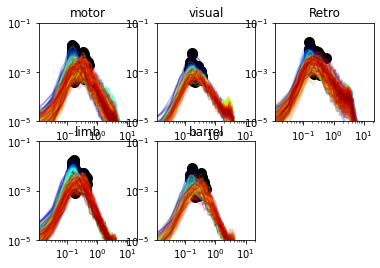

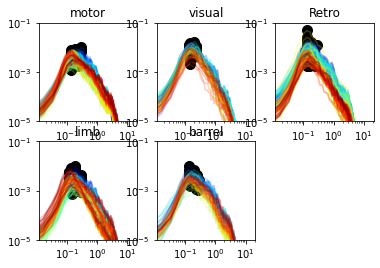

In [ ]:
####################
feats = ['motor','visual','Retro','limb','barrel']
ROI_names = saved_names.copy()
print (saved_names)
#ROI_names = feats
#codes = ['Retrosplenial', 'barrel', 'limb', 'visual','motor']

#
plotting = False
all_maxes = []
animal_ids = ['IA1','IA2','IA3',
              'IJ1','IJ2','AQ2']

plot_peak_frequency = False  # vs. plot_peak_power

#
for animal_id in animal_ids:

    if plotting:
        fig=plt.figure()

    fname_out = '/home/cat/psds_'+str(animal_id)+'_single_sessions.npy'

    psds = np.load(fname_out, allow_pickle=True)
    #cmap = matplotlib.cm.get_cmap('Paired', len(psds[session_id]))   
    cmap = matplotlib.cm.get_cmap('jet', len(psds))   

    sessions = np.arange(len(psds))
    #sessions = np.arange(0,len,5)
    print ("# sessions: ", len(sessions))
    ctr=0
    maxes = []
    for feat in feats:
        maxes.append([])
        if plotting:
            ax=plt.subplot(2,3,ctr+1)
            plt.title(feat)
        for session_id in sessions:
            for k in range(len(psds[session_id])):
                if feat in ROI_names[k]:
                    temp = psds[session_id][k]
                    #temp = psds_random[session_id][k]
                    if True:
                        temp = scipy.signal.savgol_filter(temp, 
                                                          window_length=5, 
                                                          polyorder=1, 
        #                                                   deriv=0, 
        #                                                   delta=1.0, 
        #                                                   axis=- 1, 
        #                                                   mode='interp', 
        #                                                   cval=0.0
                                                         )


                    # # plot peak frequency
                    # if plot_peak_frequency:
                    #     peaks[a].append(x[argmax])
                    # # plot frequency power
                    # elif plot_peak_power:
                    #     peaks[a].append(temp[argmax])
                    
                    #############################################
                    # print (spectra.shape)
                    x = np.arange(0,451,1)/30.
              
                    #
                    argmax = np.argmax(temp)
                    if plot_peak_frequency:
                        maxes[ctr].append([f[argmax],x[argmax]])
                    else:
                        maxes[ctr].append([f[argmax],temp[argmax]])

                    #
                    if plotting:
                        plt.scatter(f[argmax],temp[argmax],
                                   c='black',
                                   s=100)
                        plt.plot(f,temp,
                             c=cmap(session_id),
                             #label=names[k]
                                 alpha=.25
                                )

            #plt.legend()   
            if plotting:
                plt.semilogx()
                plt.semilogy()
                #plt.xlim(0,6)
                #plt.ylim(1E-4,1E6)
                plt.ylim(1E-5,1E-1)
        ctr+=1
    all_maxes.append(maxes)
if plotting:        
    plt.show()

In [13]:
##################################################################
##################################################################
##################################################################

from sklearn.linear_model import LinearRegression
from scipy import stats

#####
ids = [0,2,3]
feats = ['motor','visual','Retro','limb','barrel']
clrs_local = ['magenta','brown','pink','lightblue','darkblue']

# 
animal_id = 0

# 
fig=plt.figure(figsize=(10,10))
for ctr_animal, animal_id in enumerate(animal_ids):
    maxes = all_maxes[ctr_animal]
    ax=plt.subplot(3,2,ctr_animal+1)

    ctr=0
    for id_ in ids:
    #    ax=plt.subplot(3,1,ctr+1)
        m = np.array(maxes[id_])[:,1]    #<--------------- 0: freq; 1: power

        ##################################
        ##################################
        ##################################
        corr = stats.pearsonr(np.arange(m.shape[0]), m)


        model = LinearRegression()
        y=np.array(m).reshape(-1, 1)
        x = np.arange(y.shape[0]).reshape(-1, 1)
        model.fit(x, y)

        x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
        y_pred = model.intercept_ + model.coef_ * x2


        # compute correlation between time and location

        print ( "corr", corr)


        # compute correlation between time and location
        if corr[1]>0.05:
            plt.plot(x2, y_pred,
                 #label= str(np.round(corr,2)),
                  c=clrs_local[id_],
                  #label=feat_names[id_],
                 linewidth=6)
        else:
            plt.plot(x2, y_pred,
                 #label= str(np.round(corr,2)),
                  c=clrs_local[id_],
                  #label=feat_names[id_]+"pcor: "+str(round(corr[0],5))+
                  label="pcor: "+str(round(corr[0],2))+
                 "\npval: "+str(round(corr[1],5)),
                 linewidth=6)
        # 
        #patch = mpatches.Patch(color='grey', label=feats[id_]+ ":  "+str(round(corr[0],2)))

        # handles is a list, so append manual patch
        #labels.append(patch) 

        ##################################
        ##################################
        ##################################
        # 
        plt.scatter(np.arange(m.shape[0]), m,
                   c=clrs_local[id_],
                    edgecolor='black',
                    s=100,
                   alpha=.3)

        #
        #plt.title(feats[id_])
        ax.set_ylim(bottom=0) #0, 0.7)
        #ax.set_ylim(0, 0.04)
        ax.set_xlim(0,x[-1])
        ctr+=1
        plt.legend(fontsize=14)
    
if True:
    plt.savefig('/home/cat/fit_trends_psd_single_trials_power2.svg')
    plt.close()
else:
    plt.show()





No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


corr (-0.37517865981880355, 1.7235703434788164e-08)
corr (-0.34361018930213916, 2.889225272905296e-07)
corr (-0.6357704963380455, 2.0858373104983265e-25)
corr (-0.09208872471412914, 0.3090418875392825)
corr (-0.40892638304908896, 2.4130264367503185e-06)
corr (-0.13255413136391697, 0.1422141189714407)
corr (0.03872690419744708, 0.6224806215021097)
corr (0.034853583323691525, 0.6577192206151463)
corr (0.16410258507734138, 0.035753449719757587)
corr (0.3247245546820134, 2.7972739927185304e-05)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


corr (0.2993308058810632, 0.00012049183670800633)
corr (0.3974492362791603, 1.9509681288218603e-07)
corr (0.10110506661965864, 0.20916436286224335)
corr (0.10703432144719635, 0.18354120068016902)
corr (0.04855338053624437, 0.5472344145918647)
corr (-0.06880038618211162, 0.22860524789995587)
corr (-0.09445482279588213, 0.0979982674205848)
corr (0.23193914053156106, 3.9540184959808677e-05)


['Primary motor area, Layer 1 - right'
 'Primary motor area, Layer 1 - left'
 'Secondary motor area, layer 1 - right'
 'Secondary motor area, layer 1 - left'
 'Primary somatosensory area, barrel field, layer 1 - right'
 'Primary somatosensory area, barrel field, layer 1 - left'
 'Primary somatosensory area, lower limb, layer 1 - right'
 'Primary somatosensory area, lower limb, layer 1 - left'
 'Primary somatosensory area, upper limb, layer 1 - right'
 'Primary somatosensory area, upper limb, layer 1 - left'
 'Primary visual area, layer 1 - right'
 'Primary visual area, layer 1 - left'
 'Retrosplenial area, lateral agranular part, layer 1 - right'
 'Retrosplenial area, lateral agranular part, layer 1 - left'
 'Retrosplenial area, dorsal part, layer 1 - right'
 'Retrosplenial area, dorsal part, layer 1 - left']
(5,)
(154, 2)
0 motor  y shape:  (308,)
0 corr (0.1405136573078172, 0.013578102914561123)


NameError: name 'roi_names' is not defined

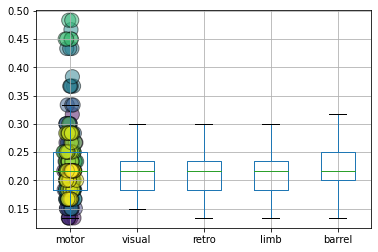

In [45]:
feats = ['motor','visual','Retro','limb','barrel']
print (ROI_names)
maxes = np.array(maxes)
print (maxes.shape)
print (np.vstack(maxes[4]).shape)
my_dict = dict(motor = np.array(maxes[0])[:,0], 
               visual = np.array(maxes[1])[:,0],
               retro = np.array(maxes[2])[:,0],
               limb = np.array(maxes[3])[:,0],
               barrel = np.array(maxes[4])[:,0]
#                    M5 = edts[4],                      
#                    M6 = edts[5]
                 )

data = pd.DataFrame.from_dict(my_dict, orient='index')
data = data.transpose()

# 
flierprops = dict(marker='o', 
                  #markerfacecolor='g', 
                  #markersize=10000,
                  linestyle='none', 
                  markeredgecolor='r')

#
data.boxplot(showfliers=False,
            flierprops=flierprops)

# manually define a new patch 
labels = []
for i,d in enumerate(data):
    y = data[d]#+np.random.uniform(data[d].shape[0])/200.-1/400.
    x = np.random.normal(i+1, 0.04, len(y))

    #
    colors = plt.cm.viridis(np.linspace(0,1,len(maxes[i])))
    x = np.random.normal(i+1, 0.04, len(maxes[i]))
    print (i,d, ' y shape: ', y.shape)
    plt.scatter(x, np.array(maxes[i])[:,0], 
               #c=clrs_local[i],
               c=colors,
               edgecolor='black',
               s=200,
               #alpha=np.linspace(.2, 1.0, x.shape[0])
               alpha=.5
               )

    # compute correlation between time and location
    from scipy import stats
    # Y and Z are numpy arrays or lists of variables 
    #print (np.arange(edts[i]).shape, y.shape)
    corr = stats.pearsonr(np.arange(y.shape[0]), y)
    #res = scipy.stats.normaltest(edts[i])
    print (i, "corr", corr)

    # 
    patch = mpatches.Patch(color='grey', label=roi_names[i]+ ":  "+str(round(corr[0],2)))

    # handles is a list, so append manual patch
    labels.append(patch) 

    # plot the legend
plt.legend(handles=labels, loc='upper center')

plt.show()




In [97]:
data = np.load('/media/cat/4TBSSD/yuki/IA1/tif_files/IA1am_Mar4_30Hz/IA1am_Mar4_30Hz_locanmf_wholestack.npz')
trials = data['whole_stack']
print (trials.shape)

(16, 40000)


In [50]:
a = np.array([[0,1]])
plt.figure(figsize=(1.5,9))
img = plt.imshow(a, cmap="viridis")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="vertical", cax=cax)
plt.savefig("/home/cat/colorbar.svg")
plt.close()

In [105]:
###############################
###### VARIANCE ANALYSIS ######
###############################


animal_id = 'AQ2'
session_name = 'all'
root_dir = '/media/cat/4TBSSD/yuki/'


# 
loca = analysis_fig4.LocaNMFClass(root_dir, animal_id, session_name)

#
loca.get_sessions(session_name)
print ("# of sessions: ", loca.sessions.shape)

session_id = 15
session = loca.sessions[session_id]
    
# load data
fname_locaNMF = os.path.join(root_dir, animal_id, 'tif_files',session,
                             session + '_locanmf.npz')

print ("fname: ", fname_locaNMF)
atlas, areas, names, locaNMF_temporal, random = load_locaNMF_data(fname_locaNMF)

# 
if atlas is not None:
    means, var = variance_locaNMF(locaNMF_temporal)
    n_trials.append(locaNMF_temporal.shape[0])
    all_means.append(means)

    means, var = variance_locaNMF(locaNMF_temporal)
    all_means_random.append(means)

    saved_names = names
    
    fig = plt.figure()
    plot_variance_locaNMF(fig, var)
    
else:
    print ('session not good')

# of sessions:  (110,)
fname:  /media/cat/4TBSSD/yuki/AQ2/tif_files/AQ2am_Dec29_30Hz/AQ2am_Dec29_30Hz_locanmf.npz
  # trials  (33, 16, 1801)


In [ ]:
###################################################
############ PLOT MEANS AND VARIANCES #############
###################################################
# 
animal_id = 'IJ1'
session_name = 'all'
root_dir = '/media/cat/4TBSSD/yuki/'

session_ids = [0,17,25,42]

colors = plt.cm.viridis(np.linspace(0,1,len(session_ids)))

random_flag = False
################################################ 
fig=plt.figure(figsize=(10,10))
for ctr,session_id in enumerate(session_ids):
    print 

    loca = load_locaNMF_temporal(animal_id, 
                                  session_name, 
                                  root_dir,
                                  session_id)

    # if using random data
    if random_flag:
        loca.locaNMF_temporal = loca.locaNMF_temporal_random
        
    ###################################################
    if atlas is not None:
        #print ("areas: ", areas)
        #print ("names: ", names)

        area_sel = 'upper limb, layer 1 - left'
        areas_selected = []
        for k in range(len(names)):
            #print ("areas", names[k])
            if area_sel in loca.names[k]:
                areas_selected.append(k)

        areas_selected = np.array(areas_selected)
        locaNMF_temporal = locaNMF_temporal[:,areas_selected]

        ##########################################

        ax=plt.subplot(2,1,1)
        clr = colors[ctr]

        plot_locanmf_temporal_averages(fig, 
                                       locaNMF_temporal,
                                      clr)
        plt.xlim(-15,0)


        ####################################################
        means, var = variance_locaNMF(locaNMF_temporal)
        all_means_random.append(means)

        saved_names = names
        ax=plt.subplot(2,1,2)
        plot_variance_locaNMF(fig, var,
                             clr)
        plt.xlim(-15,0)

        #plt.show()

if True:
    plt.savefig('/home/cat/means_vars.svg')
    plt.close()
else:
    plt.show()

In [37]:

data = np.load('/media/cat/4TBSSD/yuki/IA3/tif_files/IA3am_Mar15_30Hz/IA3am_Mar15_30Hz_locanmf.npz',
              allow_pickle=True)

A_reshape = data['A_reshape']
temp = data['temporal_trial']
names = data['areanames_area']

print (temp.shape)
mean = temp.mean(0)


fig=plt.figure()
for i in range(A_reshape.shape[2]):
    plt.subplot(4,4,i+1)
    plt.imshow(A_reshape[:,:,i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i],fontsize=6)
plt.tight_layout(h_pad=0.5,w_pad=0.5)
plt.show()




(34, 16, 1801)


In [24]:

for k in range(mean.shape[0]):
    plt.plot(mean[k,:900]+k*.1)
plt.show()

(11, 16, 1801)
